# Phys 704 Final Project

 ##### Name: Michael Bouliane 
 ##### ID: 20801403

## Part 1: 2D Ising Model

### Introduction:
To begin, the Ising model hamiltonian is given by 
\begin{equation}
\tag{1}
H = -J\sum\limits_{\langle{i,j}\rangle}\sigma_i\sigma_j 
\end{equation}
where for the sake of this project the coupling constant, $J$ is 1. In 2D the sum over nearest neighbours involves summing over the 4 bonds at each site. To model this with monte carlo methods we use the Metropolis algorithm which works as follows:

1. Pick a site at random on the lattice and compute its energy by summing over the 4 NN bonds
2. Flip the spin and re-compute the energy
3. Examine the change in energy caused by the spin flip, if the configuration is lower in energy then accept the change.
4. If the configuration is higher in energy, examine its Boltzmann factor and compare with a randomly generated number, if the Boltzmann factor is larger than the random number, accept the change
5. Repeat 

A monte carlo step in this project is defined as attempting to flip all $N = L^2$ spins once. Estimations about thermodynamic properties can be made by tracking quantities over time and averaging them as follows:

\begin{equation}
\tag{2}
\langle A \rangle = \frac{1}{m}\sum\limits_{i}^{m} A_i
\end{equation}

Where $m$ is the number of samples taken of the variable $A$ (a more detailed examination of this can be found in the implementation section). The most meaningful variables to track are the total energy per spin $E$, the energy squared per spin $E^2$, the magnetization per spin $M$ which is the order parameter for this Ising model, and finally the magnetization squared per spin $M^2$. From these we can estimate the heat capacity $C_v$ and the magnetic susceptibility $\chi$, which can be used to extract the critical exponents for the system. 

### Implementation
This project was done in Python using the `numpy`, `matplotlib`, and `multiprocess` packages. An `IsingSystem` class was created, with an initialization function that creates a lattice of spins with values $\pm 1$ of size $L \times L$ at temperature $T$. 

The function `energy` takes in an argument `idx` which is a tuple of numbers representing a site on the 2D lattice. It determines the location of that site's nearest neighbours and uses their spin values to determine the energy of site `idx`.

This is used in the function `energy_per_site` which loops over the entire lattice, summing the energy of each site and then normalizing by the total lattice size. This is the least efficient part of the code since it involves nested for loops.

Computing the magnetization using `magnetization` simply sums over the whole lattice and normalizes by the total lattice size

The main monte carlo loop is contained in the function `metropolis`. This function has arguments for the total number of monte carlo `steps`, and the fraction of beginning monte carlo steps to discard, `accept_frac`. The main loop of this function is used to track the evolution of the system's energy and magnetization, and to perform the previously mentioned thermodynamic averaging. However due to the previously mentioned inefficiency of the `energy_per_site` function, evaluating the system's total energy at every monte carlo (MC) step would massively slow down the code at very little benefit. In addition, this would give measurements which were highly correlated with one another thus affecting the statistics of the measurements. To remedy this `energy_per_site` is called after every thousand MC steps. This gives enough data for good statistics, while keeping the program's run-time reasonable and reducing the correlation between system configurations for adjacent measurements. Thus $m$ in equation 2 is not the total number of MC steps, but rather the number of samples of the variable $A$ which were taken. Another technique used to increase performance was to use pre-generation of all of the random variables needed for the calculations. The variable `idxs` is a randomly generated array of lattice sites, and `probs` are the randomly generated numbers which are then compared with the boltzmann factor. In the main loop, the relevant value can then be extracted from each of these arrays and then used in the required calculations. This is done because calling each of the relevant generation functions once to get all of the values is more efficient than calling the random generation function at each iteration of the loop. 

Finally, the function `heat_cycle` sets a range of `temps` at which to perform the `metropolis` function, using simulated annealing and returning the relevant variables as they evolve in temperature. 

This is all combined in the function `finite_scale`, which takes an argument `L` and uses it to generate an `IsingSystem` object of size `L`. The `heat_cycle` method is then called and the results are returned. This function is used to examine the finite size scaling effects of the magnetic susceptibility. Since the lattices which are examined are completely uncorrelated, we can perform this part of the calculation in parallel and compute the `heat_cycle` data for each lattice simultaneously, giving a massive performance increase.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocess as mp

font = {'size': 10}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

class IsingSystem():
    def __init__(self,T=1.,L=5):
        '''Initializes an Ising lattice of size LxL with reciprocal temperature T'''
        
        self.temp = T
        self.lattice_size = L

        self.lattice = np.random.choice((-1,1), size=(self.lattice_size, self.lattice_size))
    
    def energy(self,idx):
        '''Computes the energy of a single spin site at given location
        
        Args:
        idx: Site index of spin

        Returns:
        E: Energy of site computed with Ising hamiltonian'''

        site = self.lattice[idx]

        left = (idx[0], idx[1]-1)
        right = (idx[0], (idx[1]+1)%self.lattice_size)
        top = (idx[0]-1, idx[1])
        bottom = ((idx[0]+1)%self.lattice_size, idx[1])

        E = -site*sum((self.lattice[left], self.lattice[right], self.lattice[top], self.lattice[bottom]))
        
        return(E)

    def magnetization(self):
        '''Computes magnetization per spin
        Returns: 
        M: Absolute value of magnetization'''
        
        M = np.sum(self.lattice)
        M /= self.lattice_size**2

        return(abs(M))
    
    def energy_per_site(self):
        '''Computes the energy per spin by evaluating the Ising Hamiltonian
        
        Returns:
        E: Total system energy per spin'''
        
        E = 0.

        for i in range(self.lattice_size):
            for j in range(self.lattice_size):
                E += self.energy((i,j))
        
        E /= self.lattice_size**2

        return(E)

    def metropolis(self, steps, accept_frac):
        '''The main Monte Carlo loop function
        
        Args:
        steps: The number of times to attempt to flip all N lattice spins
        accept_frac: Fraction of steps to discard before thermodynamic averaging
        
        Returns:
        energy_array: System energy per spin at different MC times
        energy: Thermodynamic average system energy per spin
        energy2: Average of system energy squared
        mag_array: Magnetization per spin at different MC times
        mag: Average of system magnetization per spin
        mag2: Average of system magnetization per spin squared'''

        steps = int(steps)*self.lattice_size**2 
        accept_steps = int(accept_frac*steps)
                
        idxs = np.random.randint(0,self.lattice_size,(steps,2)) #random sites for spin flips
        probs = np.random.random(size=steps) #array of acceptance probabilities

        energy_array = []
        energy = 0.
        energy2 = 0.
        ei = 0.

        mag_array = []
        mag = 0.
        mag2 = 0.
        mi = 0.

        n = 0
        i_array = [] 

        for i in range(steps):
            idx = tuple(idxs[i,:])
            energy_init = self.energy(idx)
            energy_final = -energy_init

            dE = energy_final-energy_init

            # if final state is lower in energy, accept the spin flip
            if dE <= 0: 
                self.lattice[idx] = -self.lattice[idx]

            else:
                boltz_fact = np.exp(-dE/self.temp) #boltzmann weight of energy difference

                # accept the spin flip that increases energy if boltzmann weight > acceptance prob
                if probs[i]<boltz_fact:
                    self.lattice[idx] = -self.lattice[idx]

                if i % 1000 == 0:
                    ei = self.energy_per_site()
                    mi = self.magnetization()

                    energy_array.append(ei)
                    mag_array.append(mi)
                    i_array.append(i)


                    if i >= accept_steps:
                        energy += ei
                        energy2 += ei*ei

                        mag += mi
                        mag2 += mi*mi

                        n += 1

        return(np.array([i_array, energy_array]),
            energy/n,
            energy2/n,
            np.array([i_array, mag_array]),
            mag/n,
            mag2/n)

    
    def heat_cycle(self, steps, frac):
        '''Performs the metropolis function over a range of temperatures from 1 to 4 with simulated annealing
        
        Args:
        steps: Number of MC steps to perform in metropolis algorithm
        frac: discard fraction

        Returns:
        energy: <E>
        energy2: <E^2>
        mag: <M>
        mag2: <M^2>
        temps: temperature array
        '''
        
        temps = np.flip(np.concatenate((np.linspace(1, 2, 10), np.linspace(2, 3, 30), np.linspace(3, 4, 10))))
        
        energy = np.zeros(50)
        energy2 = np.zeros(50)

        mag = np.zeros(50)
        mag2 = np.zeros(50)

        for T in range(50):
            self.temp = temps[T]
            _, energy[T], energy2[T], _, mag[T], mag2[T] = self.metropolis(steps, frac)
        
        return(energy, energy2, mag, mag2, temps)    

### Part A: $E$ and $M$ Over Time

Here we examine the results of running the `metropolis` function for $1\times 10^5$ MC steps at temperatures of 1 and 1/3. In general we expect the system to start in a random configuration with some $E>E_{gs}$ and $M \approx 0$. As the system evolves the energy should decrease and the magnetization should increase before fluctuating around their equilibrium values. We can determine what these values should be using the following arguments, first for the energy:

The 2D ising model ground state for $J=1$ is a ferromagnet, with all spins aligned. This means that $\sigma_i \sigma_j = 1$ if $i,j$ are NN. This means that the hamiltonian can be expressed as:

\begin{equation}
\tag{3}
H = -\sum\limits_{\langle i,j \rangle} 1
\end{equation}

Or equivalently, we can sum over lattice sites rather than NN bonds:

\begin{equation}
\tag{4}
H = \sum\limits_i \epsilon_i 
\end{equation}

Where $\epsilon_i$ is the energy of site $i$. Since each site has 4 NN and they are all spin aligned we have that $\epsilon_i = -4$. So finally we see that:

\begin{equation}
\tag{5}
H = -\sum\limits_i 4 \implies \frac{H}{N} = -4
\end{equation}

So we should expect that the system's energy will fluctuate around -4 after it has equilibrated. This is assuming that the system is able to reach its ground state, which may not be true if the temperature used is low enough to freeze in defects.

Using a very similar argument, we expect that $\frac{|M|}{N} = 1$ is the value about which the magnetization fluctuates. 

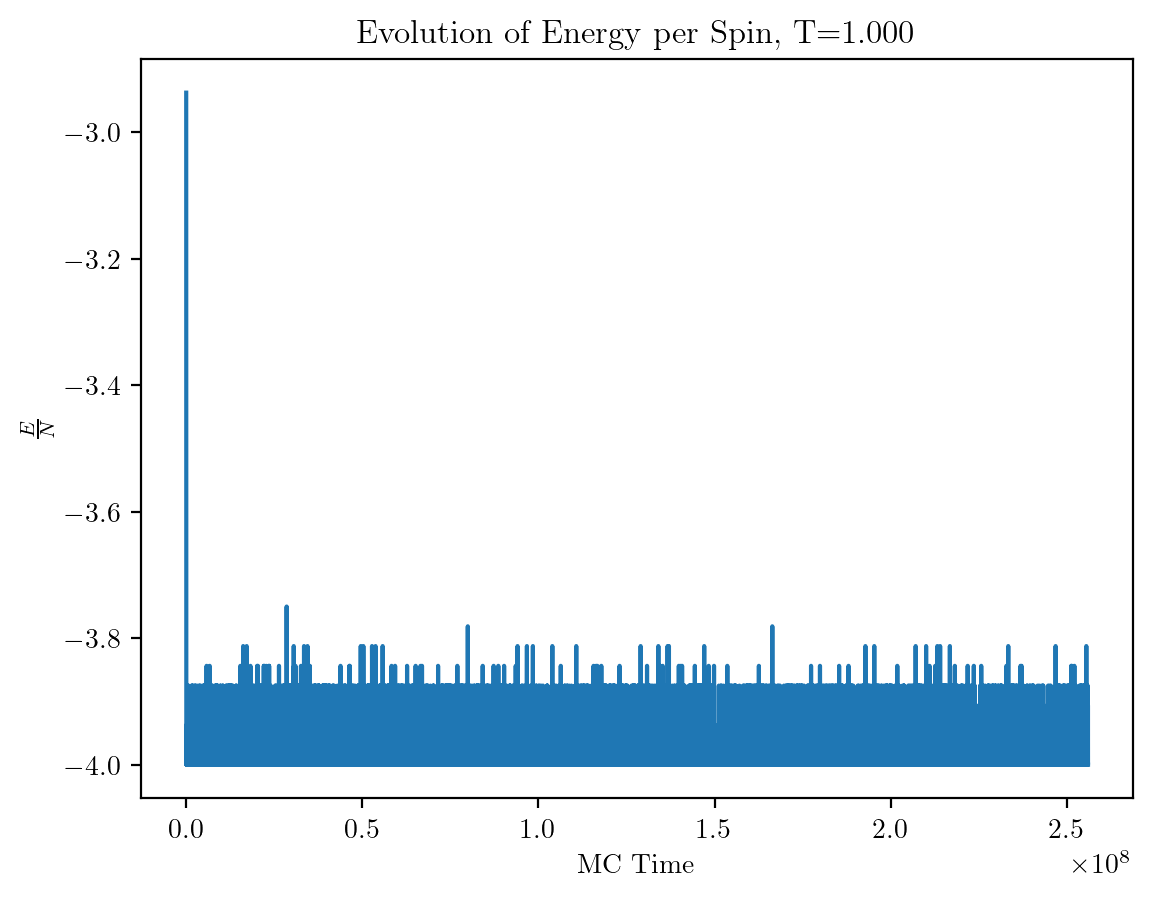

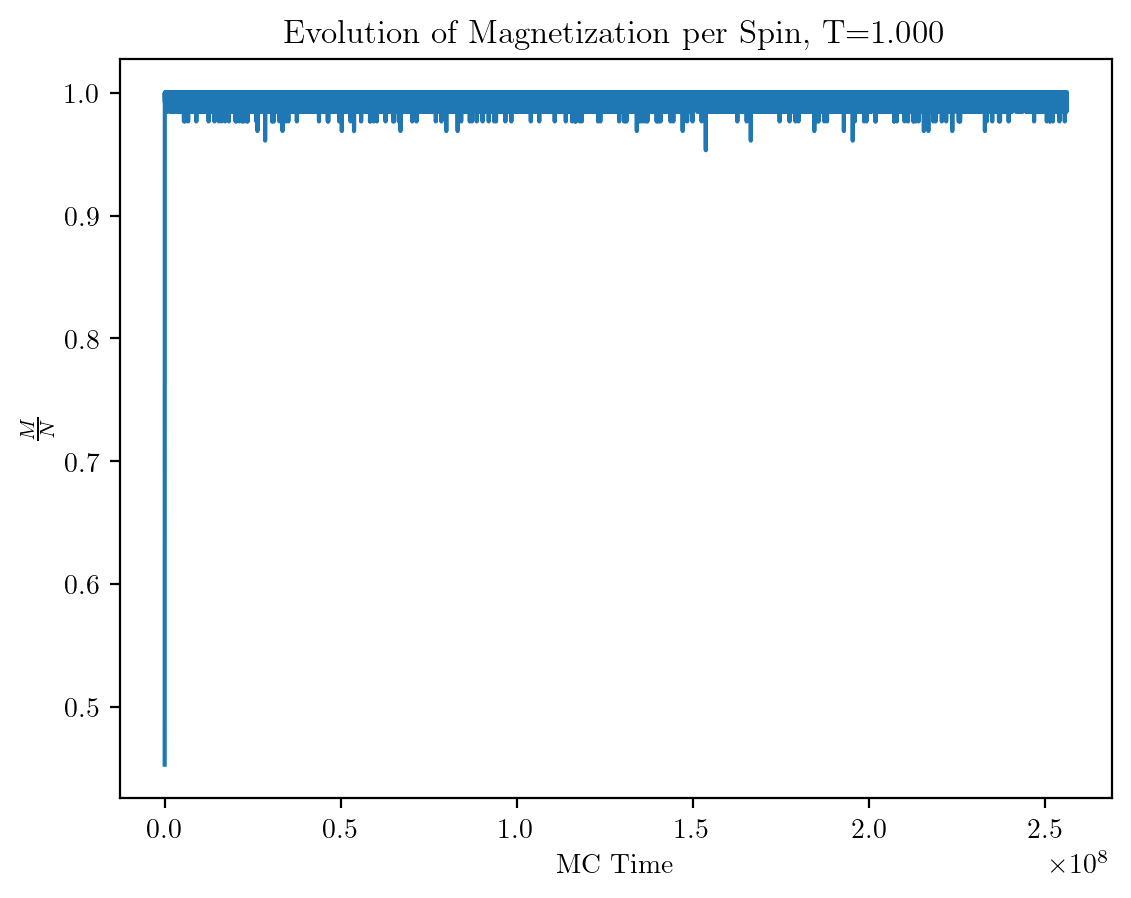

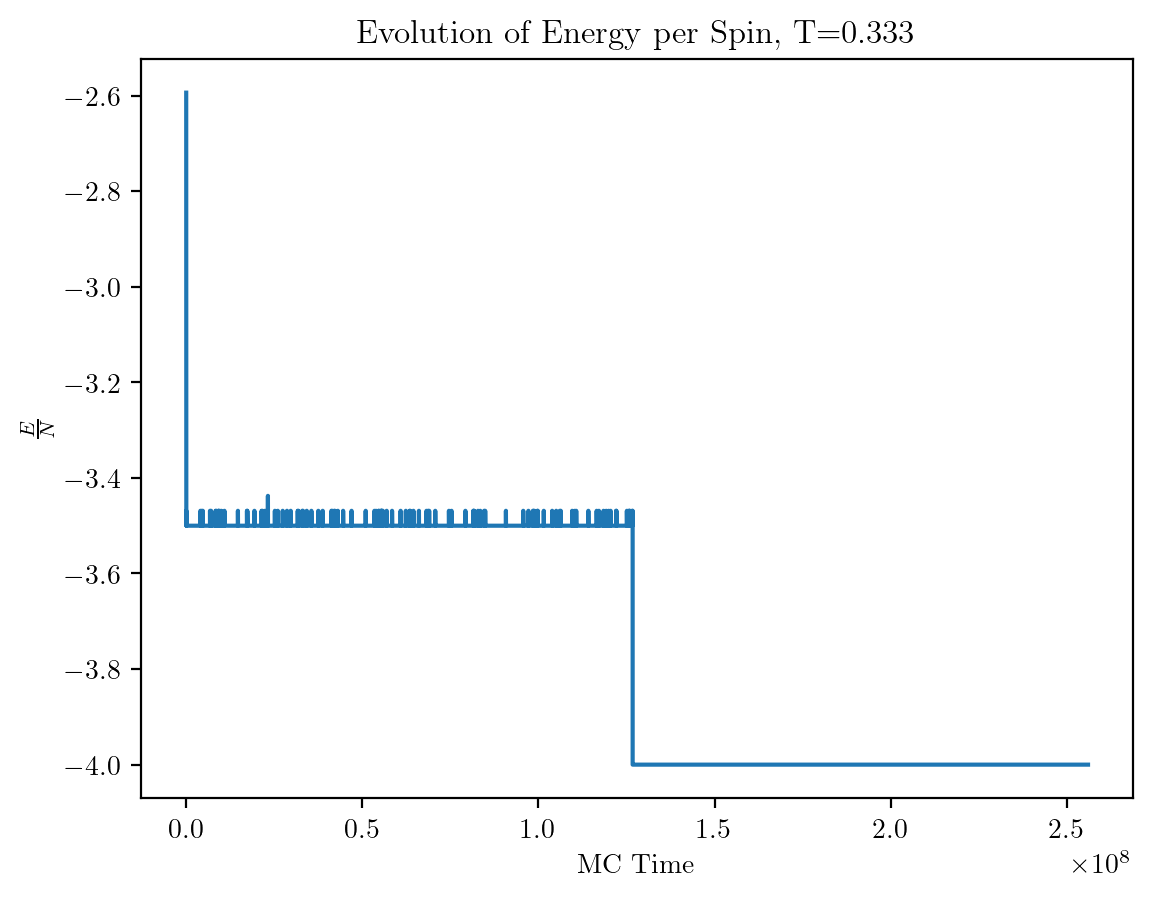

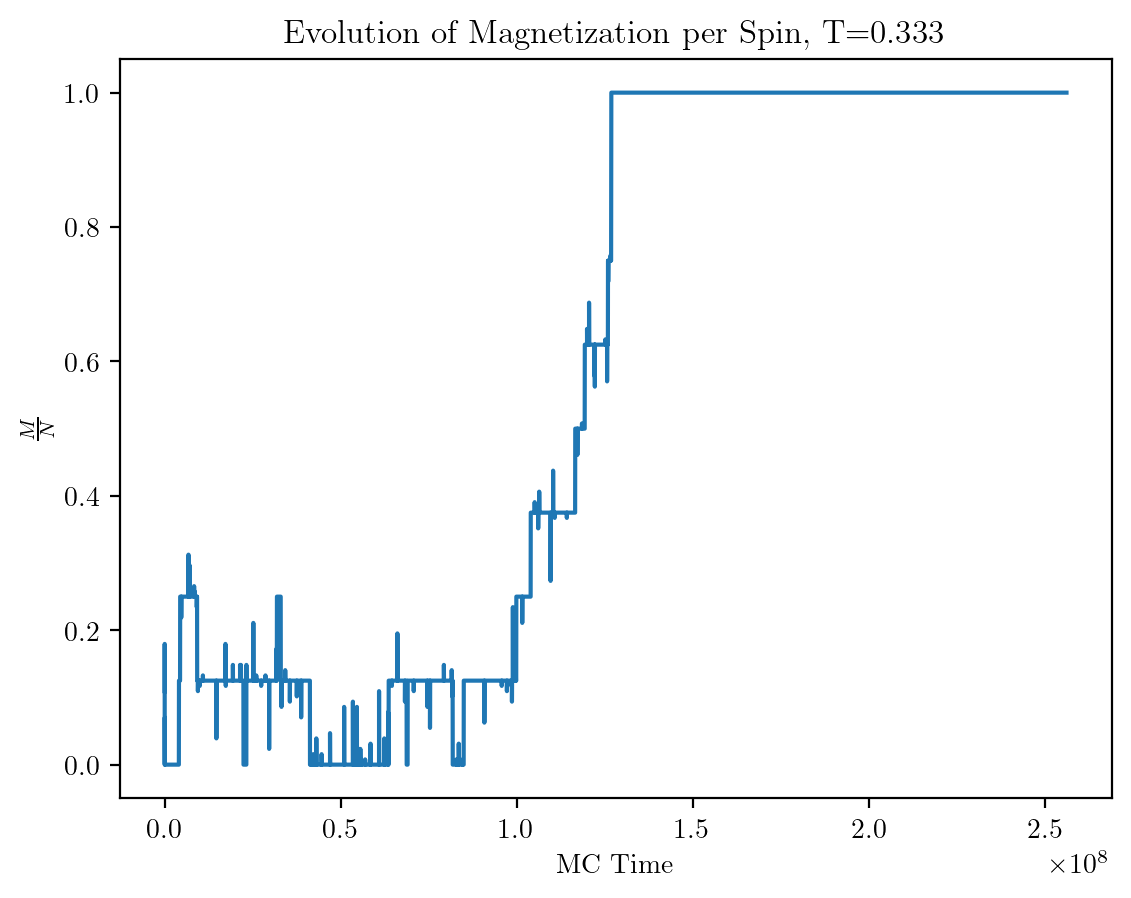

In [72]:
def partA(T):

    sys = IsingSystem(T, 16)

    energy, _, _, mag, _, _ = sys.metropolis(1e6, 0.1)
    
    plt.plot(energy[0], energy[1])
    plt.xlabel("MC Time")
    plt.ylabel(r"$\frac{E}{N}$")
    plt.title("Evolution of Energy per Spin, T={%.3f}"%T)
    plt.show()

    plt.plot(mag[0], mag[1])
    plt.xlabel("MC Time")
    plt.ylabel(r"$\frac{M}{N}$")
    plt.title("Evolution of Magnetization per Spin, T={%.3f}"%T)
    plt.show()

partA(1)
partA(1/3)

At temperature $T=1$ we find that the energy starts at some value greater than the ground state energy before quickly settling in its lowest energy configuration. Both the energy per spin and magnetization per spin align with what we predicted, and we can see that truncating the first 10% of the data leaves us with more than enough to get good statistics.

More interesting is the case of $T=1/3$, which we can see gets stuck in a local minimum for a significant amount of time. This is the disadvantage of using the metropolis algorithm without simulated annealing, as the decreased Boltzmann factor makes it harder to accept spin flips which would kick the system out of a local minimum, which is the only way for it to reach the ground state. This lower acceptance rate does have benefits however, in that it reduces the fluctuations about the equilibrium value compared to higher temperatures. 

From these plots we can conclude that the metropolis algorithm is functioning exactly as intended. 

### Running the Algorithm

Four system sizes of $L=12, 16, 20, 24$ were simultaneously run through the `heat_cycle` function to examine how $\langle E \rangle, \langle E^2 \rangle, \langle M \rangle, \langle M^2 \rangle$ evolve with temperature. Using $10^6$ MC steps the code took an outrageously long time to run (thanks Python...). The results are examined below.

In [ ]:
global finite_scale
def finite_scale(L):
    return([IsingSystem(1, L).heat_cycle(1e6, 0.1)])

Ls = [12, 16, 20, 24]
pool = mp.Pool(4) 
results = pool.map(finite_scale, Ls)
pool.close()

In [251]:
data = np.loadtxt("Ising_Data.csv", delimiter=',')

L12E = data[:,0]
L12E2 = data[:,1]
L12M = data[:,2]
L12M2 = data[:,3]

L16E = data[:,5]
L16E2 = data[:,6]
L16M = data[:,7]
L16M2 = data[:,8]

L20E = data[:,10]
L20E2 = data[:,11]
L20M = data[:,12]
L20M2 = data[:,13]

L24E = data[:,15]
L24E2 = data[:,16]
L24M = data[:,17]
L24M2 = data[:,18]

temps = data[:,4]

### Part B: $\langle E \rangle$ and $\langle M \rangle$ vs $T$

For a system size of $L=16$ we examine how the expectation values of $E$ and $M$ evolve with temperature starting at $T=4$ and cooling slowly to $T=1$.

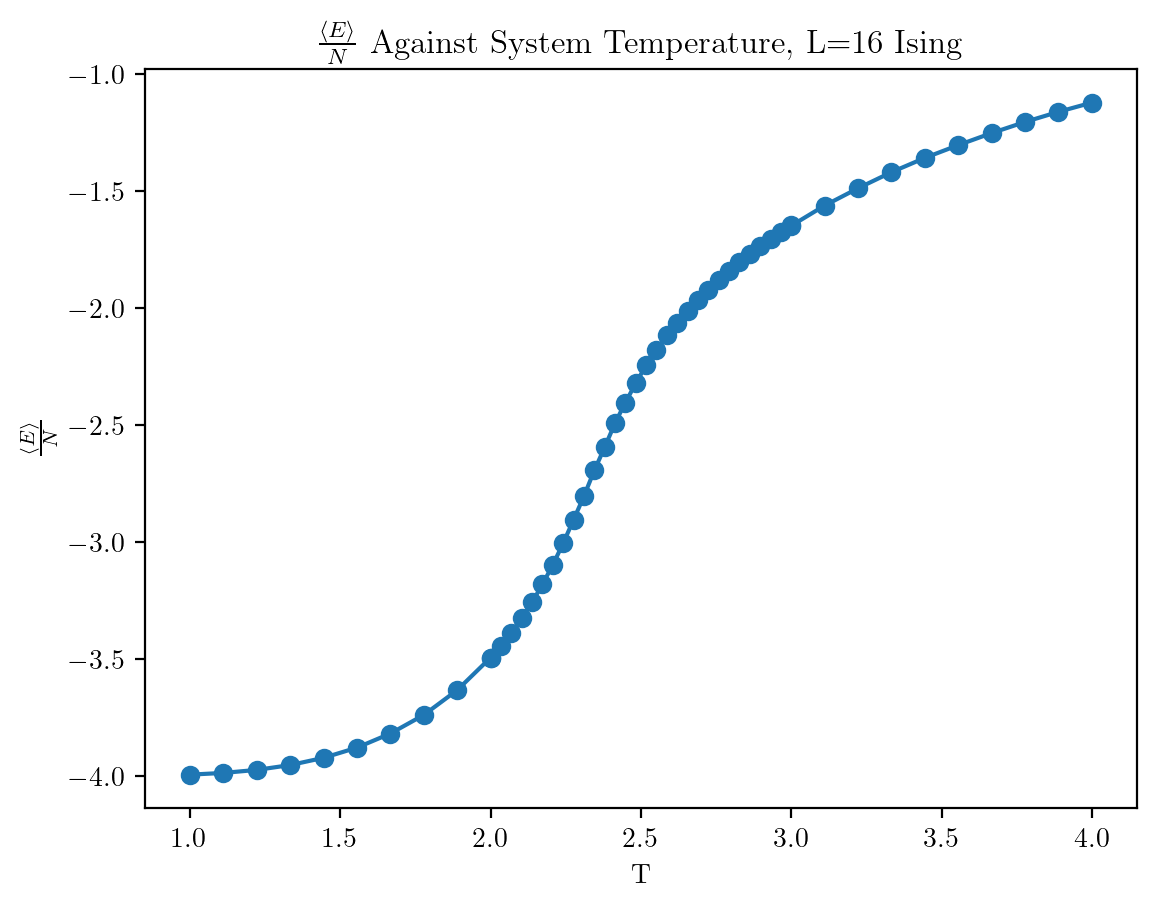

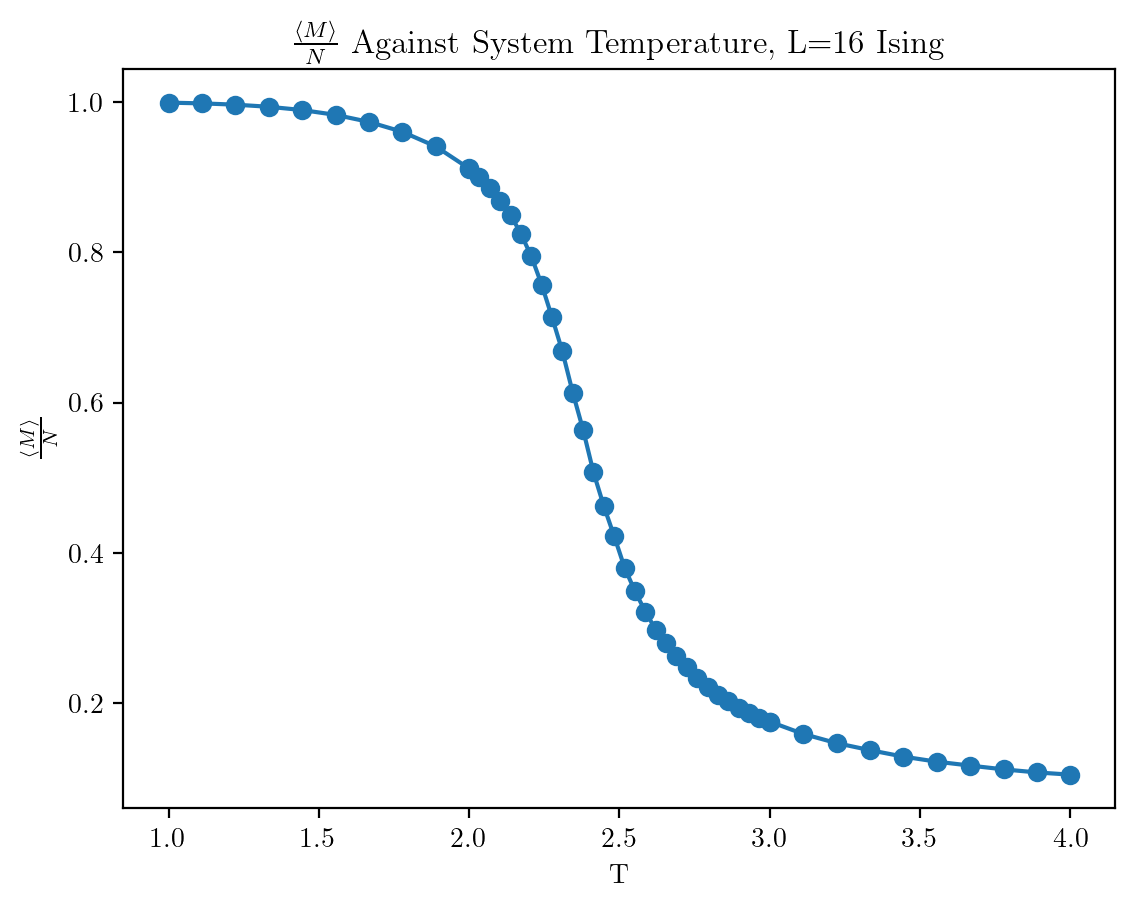

In [252]:
plt.plot(temps, L16E)
plt.scatter(temps, L16E)
plt.title(r"$\frac{\langle E \rangle}{N}$ Against System Temperature, L=16 Ising")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle E \rangle}{N}$")
plt.show()

plt.plot(temps, L16M)
plt.scatter(temps, L16M)
plt.title(r"$\frac{\langle M \rangle}{N}$ Against System Temperature, L=16 Ising")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle M \rangle}{N}$")
plt.show()

We expect that as $T\rightarrow0$ the magnetization should tend to 1 and the energy should approach -4 and that for $T\rightarrow\infty$ the magnetization tends to 0 while the energy should tend upwards. This is exactly what we obtain in the above plots. Since we allowed the system to sit so long in equilibrium ($10^6$ MC steps), and cooled slowly through the transition the measurements have very little noise and closely align with theory. 

The biggest determining factor in obtaining good results is the length of time the simulation is run for, using too few MC steps allows for the oscillations about the equilibrium value to have a greater impact on the mean value. Consider expressing the average energy as:

\begin{equation}
\tag{6}
\langle E \rangle = \frac{1}{m} \sum\limits_{i} (\bar{E} + \delta E_i) = \bar{E} + \frac{1}{m} \sum\limits_{i} \delta E_i
\end{equation}

If the fluctuations $\delta E_i$ are small, then the deviation of $\langle E \rangle$ from $\bar{E}$ decreases for an increasing number of MC steps. This is then further aided by sampling at many temperatures, with a greater density of data through the transition temperature.

### Part C: Heat Capacity and Estimation of $T_c$

First a derivation of $C_v$ in terms of $\langle E \rangle$ and $\langle E^2 \rangle$ will be given.

Starting from the definition of the expectation value of $E$ we have:
\begin{equation}
\tag{7}
\langle E \rangle = \frac{1}{Z}\sum\limits_i E_i\text{e}^{-\beta E_i} = -\frac{1}{Z}\frac{\partial Z}{\partial \beta}
\end{equation}

Next we look at the definition of the expectation value of the heat capacity:

\begin{equation}
\tag{8}
C_v = \frac{\partial \langle E \rangle}{\partial T} = \frac{\partial \langle E \rangle}{\partial \beta}\frac{\partial \beta}{\partial T}
\end{equation}

Substituting in the result from equation 7 and applying the chain rule we have:

\begin{equation}
\tag{9}
C_v = -\frac{1}{T^2}\left(\frac{1}{Z^2}\left(\frac{\partial Z}{\partial \beta}\right)^2 - \frac{1}{Z}\frac{\partial^2 Z}{\partial \beta^2}\right)
\end{equation}

Next we note that:

\begin{equation}
\tag{10}
\frac{\partial^2 Z}{\partial \beta^2} = \sum\limits_i E_i^2 \text{e}^{-\beta E_i} \implies \frac{1}{Z}\frac{\partial^2 Z}{\partial \beta^2} = \langle E^2\rangle
\end{equation}

Putting this all together we finally have that:

\begin{equation}
\tag{11}
C_v = \frac{1}{T^2}\left(\langle E^2\rangle - \langle E \rangle^2 \right)
\end{equation}

The heat capacity data for the $L=16$ lattice is presented below:

In [253]:
Cv16 = 1/temps**2 * (L16E2 - L16E**2)

Cvmax = max(Cv16)

Tc_est = temps[np.where(Cv16 == Cvmax)][0]
Tc_act = 2/np.log(1+np.sqrt(2))

pdif = float(100*abs(Tc_act-Tc_est)/Tc_act)

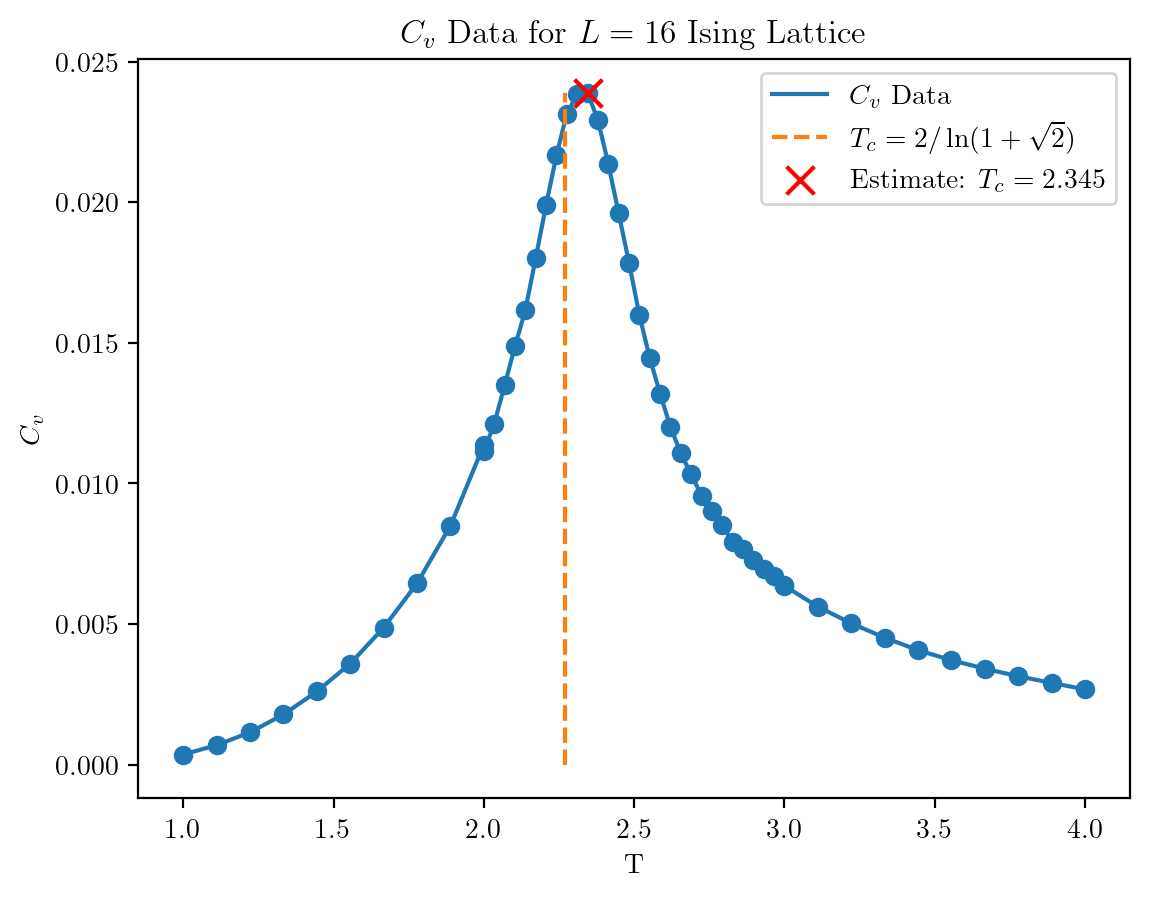

Estimate of Tc: 2.345
Error in estimate: 3.3%


In [257]:
plt.plot(temps, Cv16, label=r"$C_v$ Data")
plt.scatter(temps, Cv16)
plt.plot([Tc_act, Tc_act], [0, Cvmax], '--', label=r"$T_c = 2/\ln(1+\sqrt{2})$")
plt.scatter(Tc_est, Cvmax, marker='x', s=100, c='red', zorder=2.5, label=r'Estimate: $T_c={%.3f}$'%Tc_est)
plt.title(r'$C_v$ Data for $L=16$ Ising Lattice')
plt.ylabel(r'$C_v$')
plt.xlabel('T')
plt.legend()
plt.show()

print("Estimate of Tc: %.3f"%Tc_est)

print("Error in estimate: %.1f"%pdif + "%")

From this we find that out estimate of the critical temperature is 2.345, which compared to the actual value of $Tc$ differs by just 3.3%. The small size of the system, with just 256 lattice sites, is easily the largest contributor to the error in our estimate. We know that there are no true phase transitions at finite sized systems, and that the further we are from the thermodynamic limit the less defined the phase transition point will be. Increasing the system size is easy in principle, but would mean a considerably larger computation time with little benefit. 

A more feasible solution is to use a larger density of points around the transition temperature. This simulation used 30 points between temperatures of 2 and 3, meaning a temperature resolution of 0.033. Increasing this resolution would allow for a better estimation of the transition temperature, with much better time complexity than increasing the system size (recall the inefficiency of `energy_per_site`).

Additionally, we could instead interpolate the data with a polynomial around $T=T_c$ and determine the location of its maximum to give another measure of the critical temperature. The issue with this approach is that its validity is still determined by the temperature resolution of the simulation, meaning more calculations for what is likely the same result as simply locating the position of the max of $C_v$.

### Part D: $\chi$ and Finite Scale Collapse

The expectation of the susceptibility is defined as $\chi = \frac{\partial \langle M \rangle}{\partial h}$, and adding a magnetic field term to the hamiltonian we have $H' = H - hM$. This implies that the expectation of $M$ is given by:

\begin{equation}
\tag{12}
\langle M \rangle = \frac{1}{Z}\sum\limits_i M \text{e}^{-\beta E_i + \beta hM} = \frac{1}{Z}\frac{\partial{Z}}{\partial{\beta h}}
\end{equation}

Through the chain rule we end up with:

\begin{equation}
\tag{13}
\chi = \frac{1}{T}\left(\frac{1}{Z}\frac{\partial^2 Z}{\partial h^2} - \frac{1}{Z^2}\left(\frac{\partial Z}{\partial h}\right)^2 \right)
\end{equation}

Which gives:

\begin{equation}
\tag{14}
\chi = \frac{1}{T} \left(\langle M^2 \rangle - \langle M \rangle^2 \right)
\end{equation}

Note however that this is in terms of the total magnetization, $M = \sum_i \sigma_i$ and not the magnetization per spin $m = M/N$, accounting for this we have:

\begin{equation}
\tag{15}
\chi = \frac{N}{T} \left(\langle m^2 \rangle - \langle m \rangle^2 \right)
\end{equation}

This definition of the susceptibility poses a problem, in that $\langle M \rangle$ as mentioned in Landau and Binder $^{[1]}$, will have no peak and tend to zero for a system with $h=0$. There is also potential for large variation in this value depending on if the system, once settled in a configuration, has undergone a complete spin flipping. This is more of a concern at higher temperatures, where the probability of accepting a less energetically favourable spin (ie. perturbing out of the ground state) is higher. For these reasons we instead define the susceptibility as:

\begin{equation}
\tag{16}
\chi = \frac{N}{T} \left(\langle m^2 \rangle - \langle |m| \rangle^2\right)
\end{equation}

With this definition, we present the results for the magnetic susceptibility below:

In [259]:
chi12 = 12**2/temps*(L12M2-L12M**2)
chi16 = 16**2/temps*(L16M2-L16M**2)
chi20 = 20**2/temps*(L20M2-L20M**2)
chi24 = 24**2/temps*(L24M2-L24M**2)

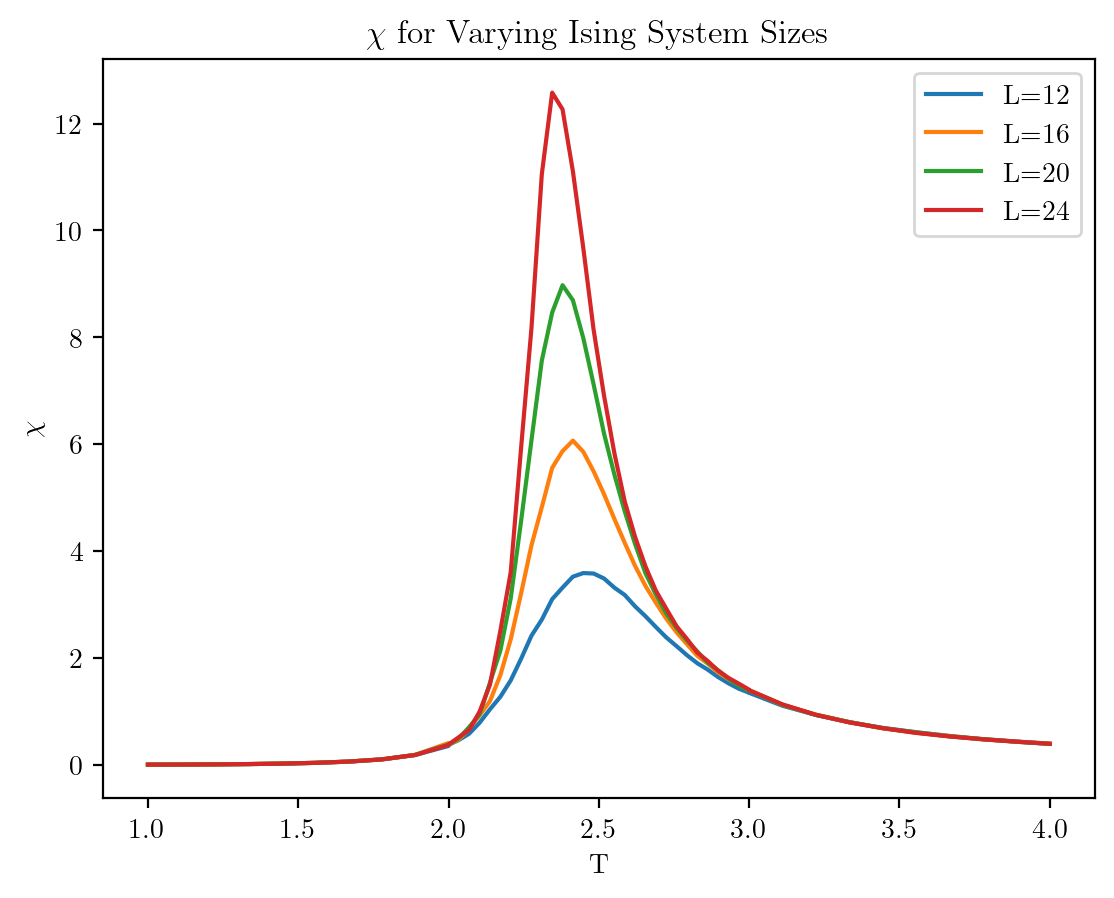

In [260]:
plt.plot(temps, chi12, label='L=12')
plt.plot(temps, chi16, label='L=16')
plt.plot(temps, chi20, label='L=20')
plt.plot(temps, chi24, label='L=24')
plt.title(r'$\chi$ for Varying Ising System Sizes')
plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.legend()
plt.show()

From this, we see a clear change in peak height and location based on the system size $L$, like we would expect for simulations of a system of finite size. Since thermodynamic quantities near a critical point can all be written in terms of a universal scaling function, we can collapse our finite size data on to that scaling function and extract the critical exponents. Specifically we use the fact that the susceptibility scales as:

\begin{equation}
\tag{17}
\chi'(t') = L^{-\gamma/\nu}\chi(t)
\end{equation}

with $t'$ given by $tL^{1/\nu}$.

The procedure for identifying the critical exponents is to simply fix the value of one, and manipulate the other until the scaled curves are as aligned as possible, and then fixing that value and manipulating the other. The is done iteratively until the curves are strongly overlapped near the transition point of $t=0$. The results of this are presented below:

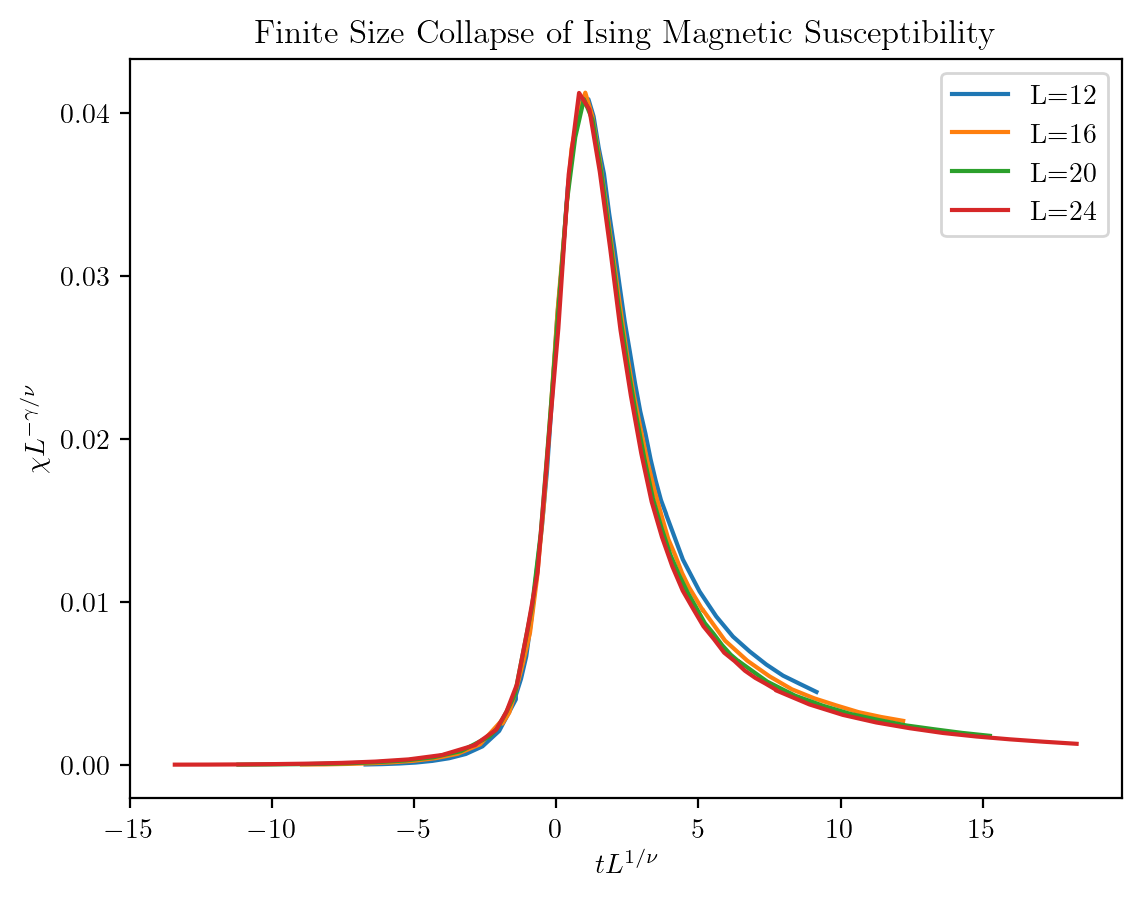

In [261]:
t = (temps-Tc_act)/Tc_act

gamma = 1.8
nu = 1

plt.plot(12**(1/nu)*t, 12**(-gamma/nu)*chi12, label='L=12')
plt.plot(16**(1/nu)*t, 16**(-gamma/nu)*chi16, label='L=16')
plt.plot(20**(1/nu)*t, 20**(-gamma/nu)*chi20, label='L=20')
plt.plot(24**(1/nu)*t, 24**(-gamma/nu)*chi24, label='L=24')
plt.title('Finite Size Collapse of Ising Magnetic Susceptibility')
plt.ylabel(r'$\chi L^{-\gamma/\nu}$')
plt.xlabel(r'$tL^{1/\nu}$')
plt.legend()
plt.show()

The exact 2D Ising model critical exponents $^{[2]}$ are given by: $\gamma = 1.75$ and $\nu=1$. From these experiments we determined that $\gamma=1.8$ and $\nu=1$ were the critical exponents which gave the best collapse. The most immediate reason for the slight disagreement is the procedure for estimating the critical exponents. If instead of estimating by hand we used a regression, we could obtain a better result with much more confidence.

The issue with this is that we have two free parameters and 4 sets of data which involves scaling both the $x$ and $y$ data. This is not an easy task to accomplish, but can be made easier using the fact that $t$ scales with $L^{1/\nu}$. Recalling the fact that $\nu = \frac{1}{y_t}$, we could perform a simple RG analysis of the zero field 2D Ising model to produce an exact value for $\nu$, which eliminates a free parameter from the regression. We could then perform a regression in $\gamma$ which attempts to minimize the distance between all four curves and as a result produces a better estimate of $\gamma$.

### Conclusions

We were successfully able to employ the Metropolis algorithm to simulate the 2D Ising model. The system's evolution both as a function of MC time and temperature perfectly aligned with expectations, and we were able to produce data which could be used to estimate the critical exponents to within 3% and the critical temperature to 3.3% in error. 

Some improvements could be made to the implementation of this model, specifically in reducing the run-time of the Metropolis algorithm. Sadly nothing can be done about the nested for-loops that are needed to make the algorithm work, but there are techniques to improve the performance of loops. Running the code on a computing cluster, for example the University's Jupyter servers, could help by simply throwing more computing power at the problem. There is also the potential of using Cython or Numba, which are Python packages dedicated to making code more performant. However neither of these play particularly well with Jupyter notebooks or an object oriented approach,which would require a complete rewrite of the project's code. 

As a result of this, we can determine that using $1\times10^6$ MC steps may be overkill for this type of project, especially on a home computer. We will instead sacrifice a small amount of smoothness of the data for a much shorter total run-time in the subsequent part of this project.

Overall, this can be viewed as a very successful simulation of the 2D Ising model, with code that can easily be extended to other hamiltonians and update rules. The most obvious extension is the 2D Potts model, which itself is an extension of the Ising model and is the subject of the second half of this report.

## Part 2: 2D Potts Model

### Introduction

The Potts model is an extension to the Ising model with hamiltonian defined as:

\begin{equation}
\tag{18}
H = -J\sum\limits_{\langle i,j \rangle}\delta_{\sigma_i\sigma_j}
\end{equation}

where $\sigma_i$ is the spin value of a lattice site, taking an integer value from 1 to $q$. Taking $J=1$ we have a ferromagnetic system with a $q$-fold degenerate ground state. While it is true that the 2D Ising model is equivalent to the $q=2$ Potts model, we need to take more care in defining an order parameter which tracks the transition from the PM to FM state. 

We expect there to be clusters of aligned spins, each with their own $\sigma_i$ value, since the hamiltonian only cares about aligned spins and not their magnitudes. Next, let each spin value have an occupation number $n_i$ such that $N = \sum\limits_i n_i$. We then define a 'magnetization' by determining the spin state with maximal occupancy, and finding its proportion of the total number of spins:

\begin{equation}
\tag{19}
M = \frac{\max(n_i)}{N}
\end{equation}

To see why this is a meaningful way to track the phase transition, consider the following example:

A $q=3$ system is on an $L=10$ lattice. The occupancies are $n_1 = 10$, $n_2 = 85$, and $n_3 = 5$. Since $\sigma=2$ is the maximally occupied state, the magnetization is given by $M = n_2/N = 85/100 = 0.85$. If the system undergoes a cluster flip, where all of the 85 $\sigma=2$ states become $\sigma=3$ states, the magnetization increases to reflect this, becoming $M=0.9$. However, if the spins are split among $\sigma=1$ and $\sigma=3$, the magnetization will instead decrease. Since this is analogous to the regular Ising model magnetization, the associated susceptibility is simply:

\begin{equation}
\tag{20}
\chi = \frac{N}{T}\left(\langle M^2 \rangle - \langle M \rangle^2\right)
\end{equation}

Where we no longer need the absolute value of $M$ since all $\sigma_i$ are greater than zero. 

The implementation of this will be nearly identical to the 2D Ising model, with only slight changes to account for the new hamiltonian and update rule.

### New MCMC Update Rule

We will still apply the Metropolis algorithm for single spin flips (though there are methods which use cluster flipping instead), however we can't simply take a spin and 'flip' it for this system. Instead we will randomly generate a value $\delta \sigma$ and update a randomly selected spin state $\sigma_i$ such that $\sigma_i' = \sigma_i + \delta \sigma$. If this would push $\sigma_i$ above $q$, we simply loop back around and start counting up from 1. 

The $\delta \sigma$'s will be generated over the range $[-q+1, q-1]$, and this range shrinks the longer the code runs to increase the acceptance rate towards the end. 

The system energy is calculated with the hamiltonian, and the exact same acceptance conditions from the Metropolis algorithm are used. 

In [2]:
import scipy as sp
import pandas as pd

class PottsSystem():
    def __init__(self,T=1.,L=5, q=3):
        '''Initializes a Potts lattice of size LxL with temperature T and maximal spin value q'''
        
        self.temp = T
        self.lattice_size = L
        self.q = q
        self.N = self.lattice_size**2

        self.lattice = np.random.choice(range(1,q+1), size=(self.lattice_size, self.lattice_size))

    def delta(self, idx1, idx2):
        '''Helper function: Kronecker delta of two spins'''
        if self.lattice[idx1] == self.lattice[idx2]:
            return(1)
        else:
            return(0)
    
    def energy(self,idx):
        '''Computes the energy of a single spin site at given location
        
        Args:
        idx: Site index of spin

        Returns:
        E: Energy of site computed with Potts hamiltonian'''

        left = (idx[0], idx[1]-1)
        right = (idx[0], (idx[1]+1)%self.lattice_size)
        top = (idx[0]-1, idx[1])
        bottom = ((idx[0]+1)%self.lattice_size, idx[1])

        E = -(self.delta(idx, left) + self.delta(idx, right) + self.delta(idx, top) + self.delta(idx, bottom))
        
        return(E)

    def magnetization(self):
        '''Computes magnetization per spin
        Returns: 
        M: Magnetization'''
        
        sigma_max = sp.stats.mode(self.lattice, axis=None, keepdims=False)

        return(sigma_max[1]/self.N)
    
    def energy_per_site(self):
        '''Computes the energy per spin by evaluating the Potts Hamiltonian
        
        Returns:
        E: Total system energy per spin'''

        E = 0.

        for i in range(self.lattice_size):
            for j in range(self.lattice_size):
                E += self.energy((i,j))
        
        E /= self.N

        return(E)
    
    def update(self, idx, delta_sigma, prob):
        '''Applies the newly defined MC update rule by shifting a spin value by delta_sigma
        
        Args:
        idx: location on lattice to attempt spin flip
        delta_sigma: shift to apply to sigma value at site idx
        prob: randomly generated probability used to compare to the boltzmann factor'''

        sigma = self.lattice[idx]

        Ei = self.energy(idx)

        if sigma+delta_sigma > self.q:
            sigma_prime = (delta_sigma - (self.q - sigma))
        elif sigma+delta_sigma < 1:
            sigma_prime = self.q + (delta_sigma + sigma)
        else:
            sigma_prime = sigma + delta_sigma
        
        self.lattice[idx] = sigma_prime

        Ef = self.energy(idx)

        dE = Ef - Ei
        
        if dE > 0 and np.exp(-dE/self.temp) < prob:
            self.lattice[idx] = sigma


    def metropolis(self, steps, accept_frac):
        '''The main Monte Carlo loop function
        
        Args:
        steps: The number of times to attempt to flip all N lattice spins
        accept_frac: Fraction of steps to discard before thermodynamic averaging
        
        Returns:
        energy_array: System energy per spin at different MC times
        energy: Thermodynamic average system energy per spin
        energy2: Average of system energy squared
        mag_array: Magnetization per spin at different MC times
        mag: Average of system magnetization per spin
        mag2: Average of system magnetization per spin squared'''

        steps = int(steps)*self.lattice_size**2 
        accept_steps = int(accept_frac*steps)
                
        idxs = np.random.randint(0,self.lattice_size,(steps,2)) #random sites for spin flips
        probs = np.random.random(size=steps) #array of acceptance probabilities
        
        delta_sigmas = np.concatenate((np.random.choice(
                np.concatenate((range(-self.q+1, 0), range(1, self.q))), steps//2
            ),
            np.random.choice(
                np.concatenate((range(-self.q//2, 0), range(1, self.q//2))), steps//4
            ),
            np.random.choice((-1, 1), steps//4)
            )
            ) #randomly generated delta_sigmas which have a shrinking range as MC time progresses

        energy_array = []
        energy = 0.
        energy2 = 0.
        ei = 0.

        mag_array = []
        mag = 0.
        mag2 = 0.
        mi = 0.

        n = 0
        i_array = [] 

        for i in range(steps):
            idx = tuple(idxs[i,:])
            
            self.update(idx, delta_sigmas[i], probs[i])

            if i % 1000 == 0:
                ei = self.energy_per_site()
                mi = self.magnetization()

                energy_array.append(ei)
                mag_array.append(mi)
                i_array.append(i)

                if i >= accept_steps:
                    energy += ei
                    energy2 += ei*ei

                    mag += mi
                    mag2 += mi*mi

                    n += 1

        return(np.array([i_array, energy_array]),
            energy/n,
            energy2/n,
            np.array([i_array, mag_array]),
            mag/n,
            mag2/n)

    
    def cool_cycle(self, steps, frac):
        '''Performs the metropolis function over a range of temperatures from Tc+0.5 to Tc-0.5 with simulated annealing
        
        Args:
        steps: Number of MC steps to perform in metropolis algorithm
        frac: discard fraction

        Returns:
        energy: <E>
        energy2: <E^2>
        mag: <M>
        mag2: <M^2>
        temps: temperature array
        '''
        Tc = 1/np.log(1+np.sqrt(self.q))
        
        temps = np.flip( np.concatenate((np.linspace(Tc-0.5, Tc-0.1, 10), np.linspace(Tc-0.09, Tc+0.09, 30), np.linspace(Tc+0.1, Tc+0.5, 10))))
        
        energy = np.zeros(50)
        energy2 = np.zeros(50)

        mag = np.zeros(50)
        mag2 = np.zeros(50)

        for T in range(50):
            self.temp = temps[T]
            _, energy[T], energy2[T], _, mag[T], mag2[T] = self.metropolis(steps, frac)
        
        return(energy, energy2, mag, mag2, temps) 

    def heat_cycle(self, steps, frac):
        '''Cools over a range of temperatures from Tc-0.5 to Tc+0.5
        
        Args:
        steps: Number of MC steps to perform in metropolis algorithm
        frac: discard fraction

        Returns:
        energy: <E>
        energy2: <E^2>
        mag: <M>
        mag2: <M^2>
        temps: temperature array
        '''

        Tc = 1/np.log(1+np.sqrt(self.q))
        
        temps = np.concatenate((np.linspace(Tc-0.5, Tc-0.1, 10), np.linspace(Tc-0.09, Tc+0.09, 30), np.linspace(Tc+0.1, Tc+0.5, 10)))
        
        energy = np.zeros(50)
        energy2 = np.zeros(50)

        mag = np.zeros(50)
        mag2 = np.zeros(50)

        for T in range(50):
            self.temp = temps[T]
            _, energy[T], energy2[T], _, mag[T], mag2[T] = self.metropolis(steps, frac)
        
        return(energy, energy2, mag, mag2, temps)
    
    def hysteresis(self):
        '''Looks for hysteresis of first order transition by first cooling the system to an ordered state, 
        then heating back through the transition'''
        
        cool_data = self.cool_cycle(1e5, 0.1)
        heat_data = self.heat_cycle(1e5, 0.1)

        return(cool_data, heat_data)


### Part A: Examining the Performance of the MC Algorithm, $q=3$

Here we examine the evolution of the energy and magnetization as a function of Monte Carlo time, at a temperature of $T=1$, which is just above the transition temperature, and $T=1/3$ which is well below the transition temperature ($T_C \approx 0.995$). Our expectations are exactly the same as for the 2D Ising model: we expect the energy per spin to tend down to -4 in the ordered state, and the magnetization per spin to tend towards 1 in the ordered state. We do not expect a phase transition to occur for the $T=1$ system.

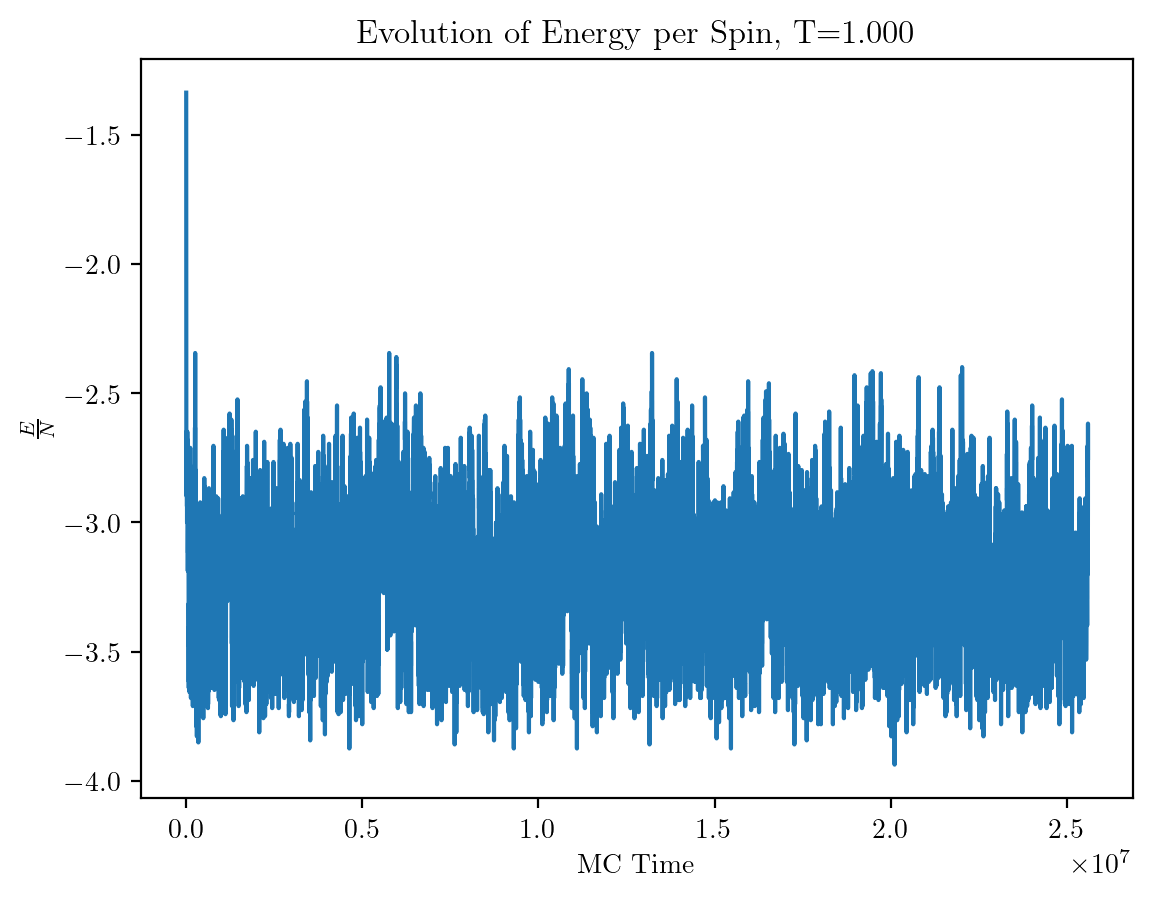

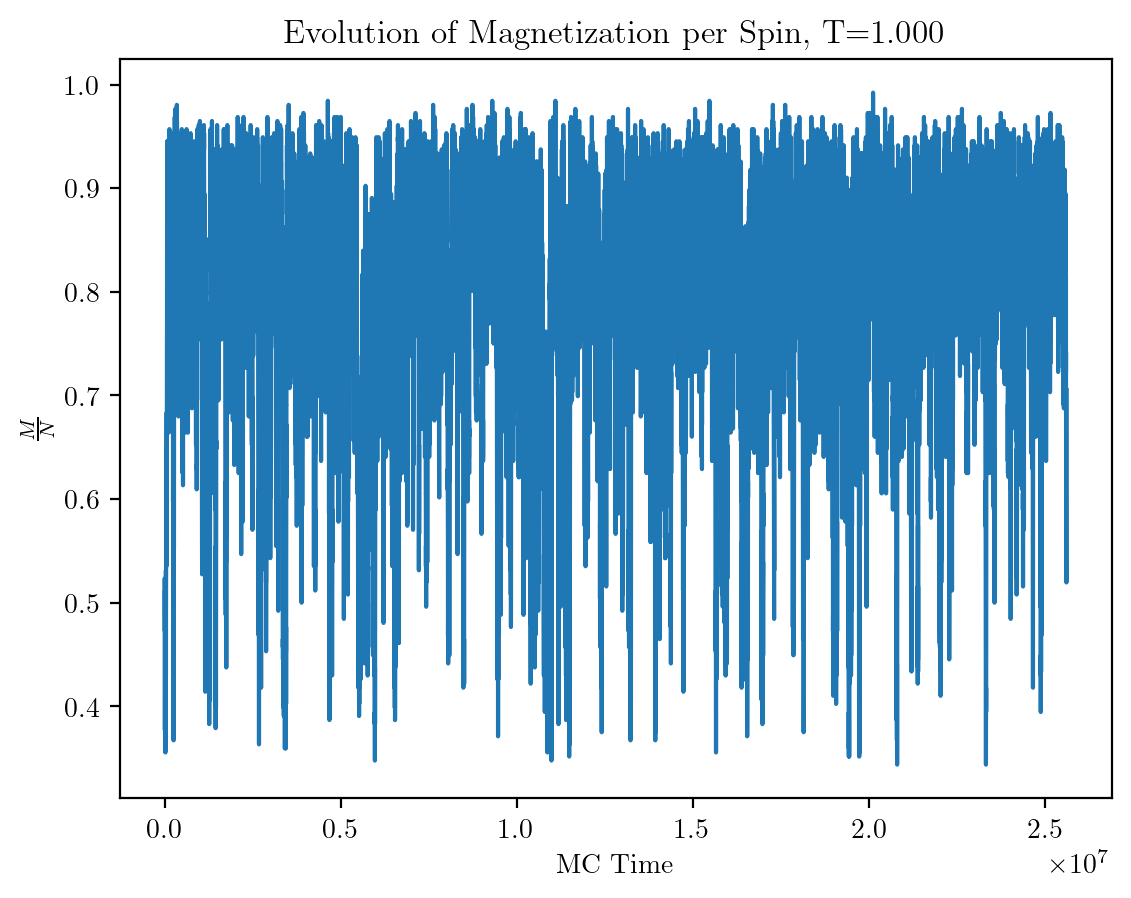

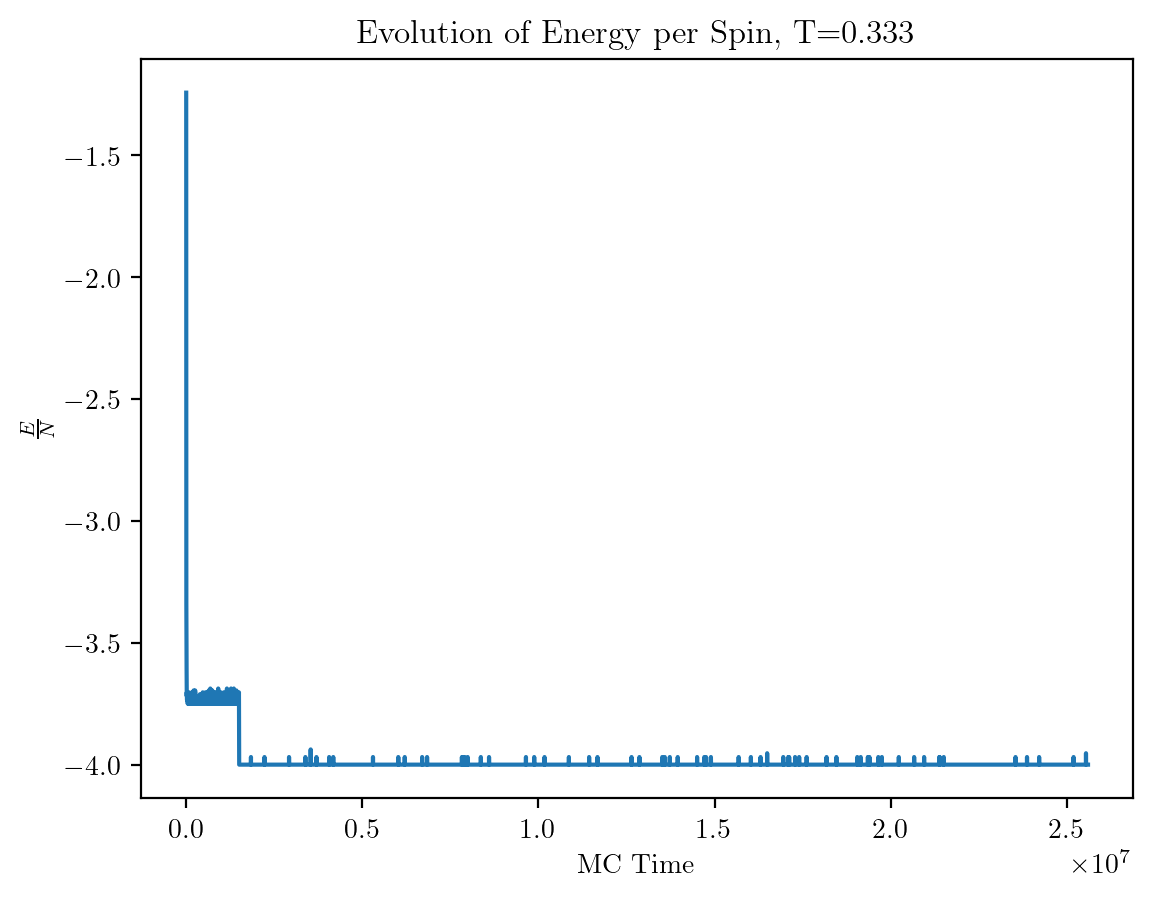

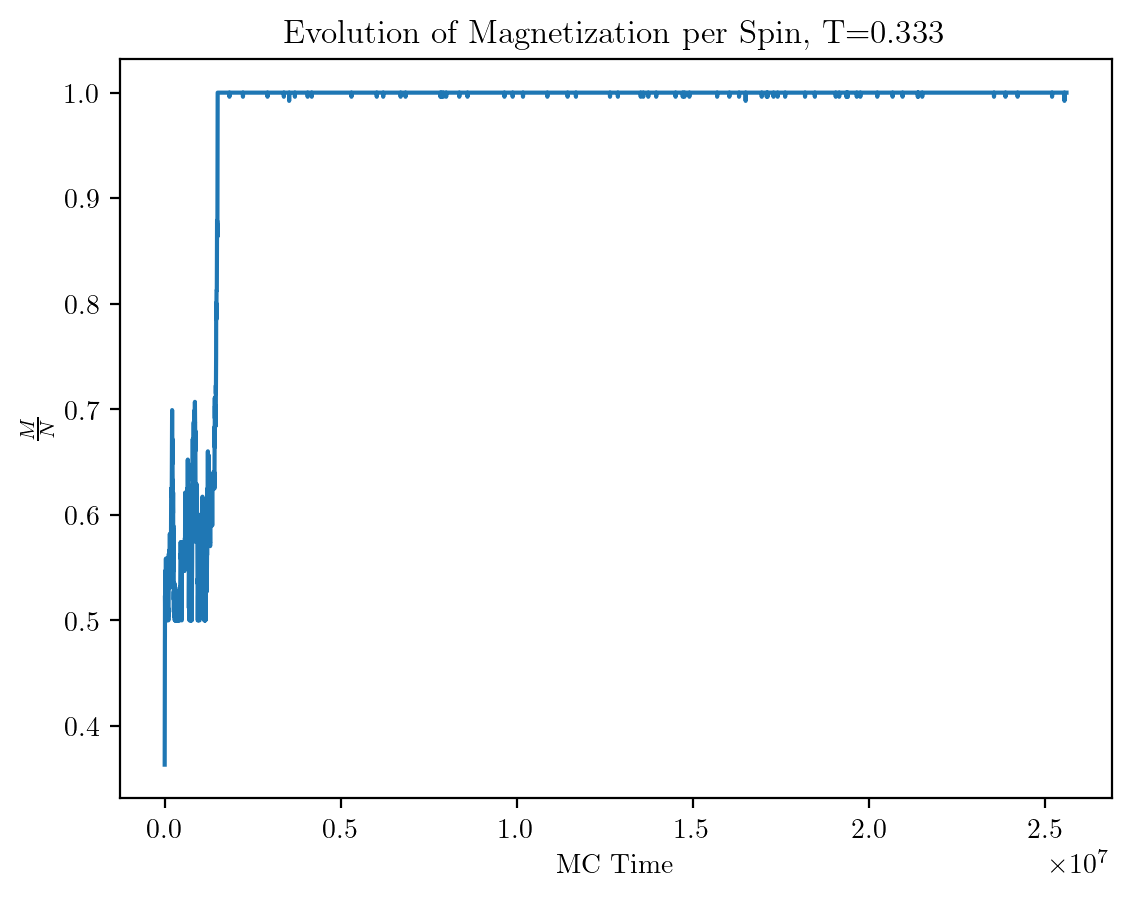

In [73]:
def MC_time_evolution(T):

    sys = PottsSystem(T, 16, 3)

    energy, _, _, mag, _, _ = sys.metropolis(1e5, 0.1)
    
    plt.plot(energy[0], energy[1])
    plt.xlabel("MC Time")
    plt.ylabel(r"$\frac{E}{N}$")
    plt.title("Evolution of Energy per Spin, T={%.3f}"%T)
    plt.show()

    plt.plot(mag[0], mag[1])
    plt.xlabel("MC Time")
    plt.ylabel(r"$\frac{M}{N}$")
    plt.title("Evolution of Magnetization per Spin, T={%.3f}"%T)
    plt.show()

MC_time_evolution(1)
MC_time_evolution(1/3)

These results exactly match our expectations, and it is interesting to note that for the system near the transition, the energy is being minimized but the large fluctuations in both $E$ and $M$ show that the spins have not settled into an ordered state. This is evidence of the formation of clusters, and their subsequent flipping. 

If we look at the results for $T=1/3$ we see a clear evolution towards an ordered state, with very small fluctuations about the mean values. This is likely a combination of both the low temperature, but also the shrinking range of $\delta q$'s which should help to remove and prevent the formation of defects. 

This seems to show that our implementation of the Metropolis algorithm is successfully minimizing the system's total energy. Though this is not evidence that our definition of $M$ is physically meaningful to this system. For that, we must examine its evolution in temperature. 

### Collecting the Data for $q=3$

Here we run the same (now renamed) `cool_cycle` function for system sizes of $L=12,16,20,24$, and will examine the data for $L=16$ in the subsequent parts. Note here that we are using $1\times10^5$ MC steps, which we expect to lead to slightly noisier data but which can be acquired much faster. 

In [3]:
global potts_finite_scale3
def potts_finite_scale3(L):
    return(PottsSystem(1, L, 3).cool_cycle(1e5, 0.1))

Ls = [12, 16, 20, 24]
pool = mp.Pool(4) 
results = pool.map(potts_finite_scale3, Ls)
pool.close()

In [5]:
datafile = np.stack([results[i][j] for i in range(4) for j in range(5)], axis=1)
datafile = pd.DataFrame(datafile)
datafile.to_csv('q3_potts data.csv', index=False, header=False)

In [262]:
data = np.loadtxt("q3_potts data.csv", delimiter=',')

L12E = data[:,0]
L12E2 = data[:,1]
L12M = data[:,2]
L12M2 = data[:,3]

L16E = data[:,5]
L16E2 = data[:,6]
L16M = data[:,7]
L16M2 = data[:,8]

L20E = data[:,10]
L20E2 = data[:,11]
L20M = data[:,12]
L20M2 = data[:,13]

L24E = data[:,15]
L24E2 = data[:,16]
L24M = data[:,17]
L24M2 = data[:,18]

temps = data[:,4]

### Part B: Examining the Temperature Evolution of $\langle \frac{E}{N} \rangle$ and $\langle \frac{M}{N} \rangle$

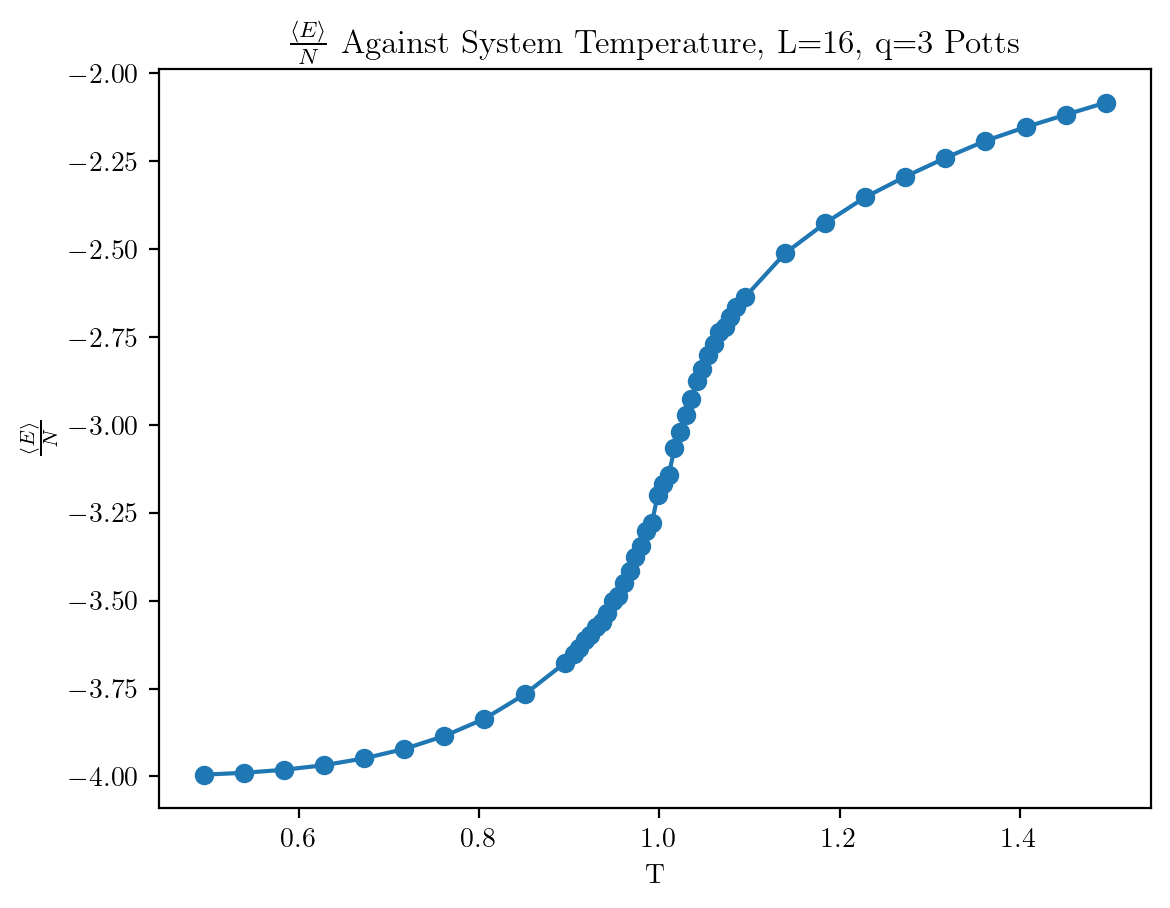

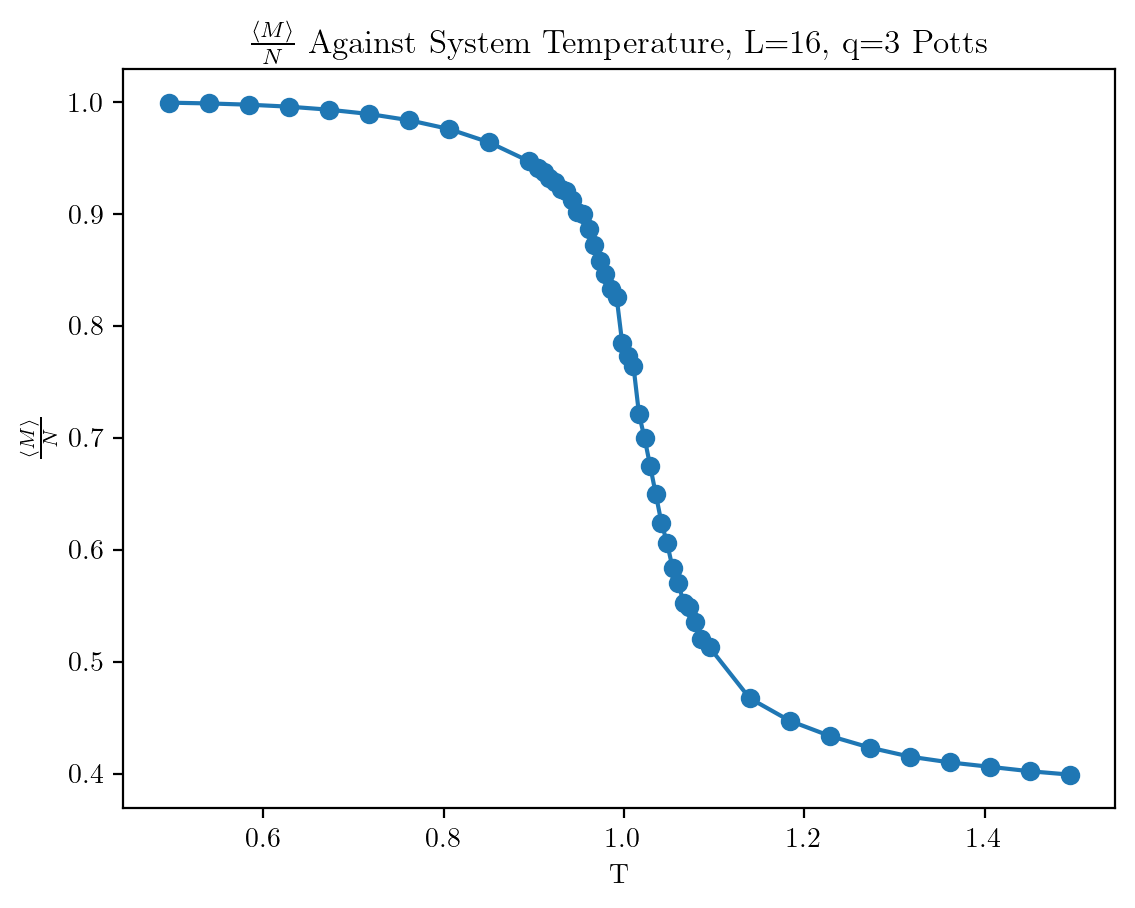

In [264]:
plt.plot(temps, L16E)
plt.scatter(temps, L16E)
plt.title(r"$\frac{\langle E \rangle}{N}$ Against System Temperature, L=16, q=3 Potts")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle E \rangle}{N}$")
plt.show()

plt.plot(temps, L16M)
plt.scatter(temps, L16M)
plt.title(r"$\frac{\langle M \rangle}{N}$ Against System Temperature, L=16, q=3 Potts")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle M \rangle}{N}$")
plt.show()

We can use the plot of the average magnetization to see if it acts as an effective order parameter. If we compare this with the Ising model plot, we see that the residual magnetization for the Potts model is much larger than that of the Ising model, which tends close to zero at the higher temperatures. An order parameter is defined as a value which is zero in the disordered phase, and one in the ordered phase. From our definition of $M$, assuming a uniform distribution of $\sigma_i$, we find that $M$ should have a minimum of around $1/q$ in the disordered phase, which is only zero for $q\rightarrow\infty$. To address this we could simply rescale this using:

\begin{equation}
\tag{21}
M \rightarrow \frac{M - \min(M)}{\max(M) - \min(M)}
\end{equation}

Knowing that our magnetization should be 1 in the ordered phase, and have a minimum value of $1/q$ in the disordered phase, this gives a new definition of $M$:

\begin{align}
\tag{22}
M &= \frac{\frac{\max(n_i)}{N}-\frac{1}{q}}{1-\frac{1}{q}}\\
\tag{23}
\implies M &= \frac{N-q\max(n_i)}{N(1-q)}
\end{align}

If we compare this with literature $^{[3]}$, we find that this is exactly how the order parameter is defined for the 2D Potts model. The good thing is that while the code computes the incorrect magnetization, we can apply that simple transformation in equation 22 after the fact and obtain something which does tend toward zero in the disordered phase. We can also apply this to the $M^2$ data, which we would expect to have a minimum of $1/q^2$ and a maximum of 1.

In [265]:
L12M = (L12M-(1/3))/(1-(1/3))
L16M = (L16M-(1/3))/(1-(1/3))
L20M = (L20M-(1/3))/(1-(1/3))
L24M = (L24M-(1/3))/(1-(1/3))

L12M2 = (L12M2-(1/9))/(1-(1/9))
L16M2 = (L16M2-(1/9))/(1-(1/9))
L20M2 = (L20M2-(1/9))/(1-(1/9))
L24M2 = (L24M2-(1/9))/(1-(1/9))

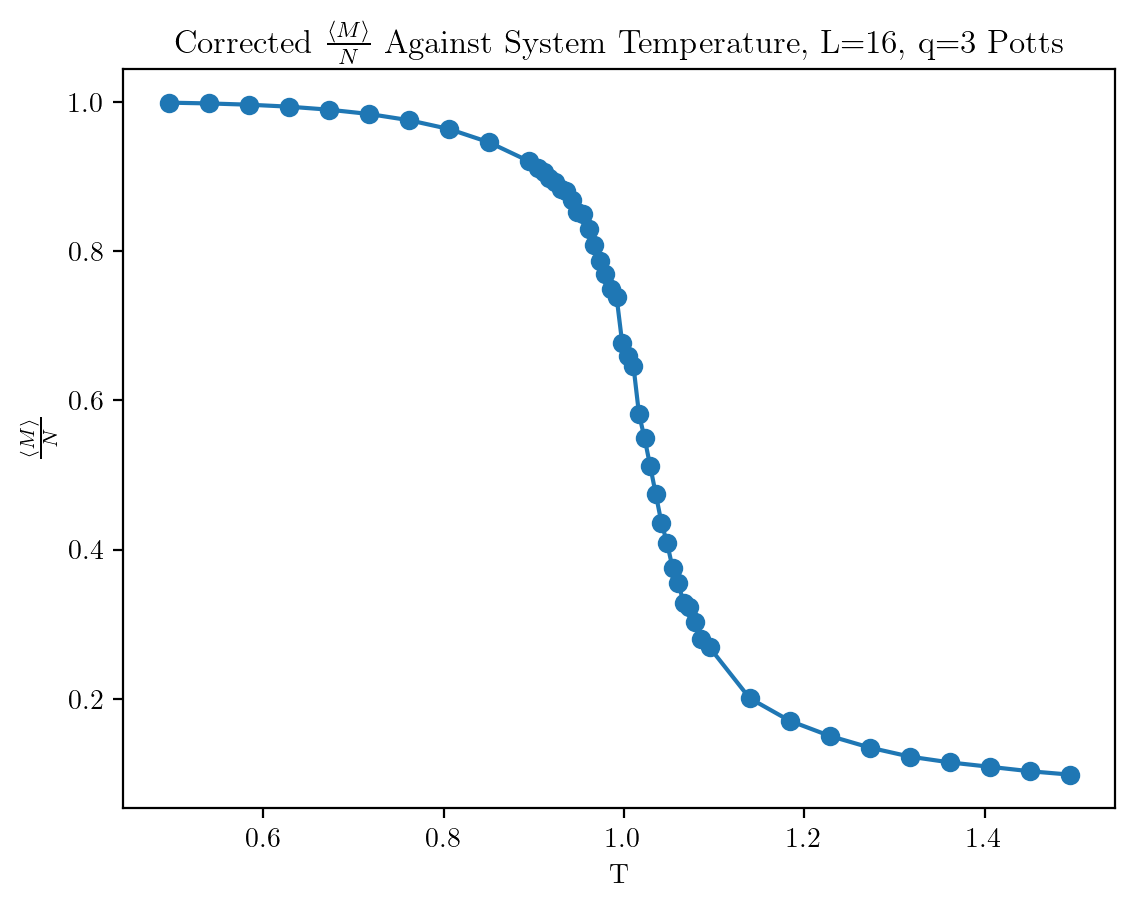

In [266]:
plt.plot(temps, L16M)
plt.scatter(temps, L16M)
plt.title(r"Corrected $\frac{\langle M \rangle}{N}$ Against System Temperature, L=16, q=3 Potts")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle M \rangle}{N}$")
plt.show()

With this transformation applied, we see that these qualitatively look much closer to what we obtained in part 1 for the 2D Ising model. From this, we can now correctly compute the magnetic susceptibility, and the heat capacity from the energy data.

### Part C: $C_v$ and $T_c$ Estimation

The heat capacity is computed in the exact same way as for the 2D Ising model, and we follow the same procedure for estimating the critical temperature. Since we used one tenth of the MC steps here as for the Ising model, we should expect the data to be slightly noisier which should negatively impact how well we can estimate $T_c$. 

In [267]:
Cv16 = 1/temps**2 * (L16E2 - L16E**2)

Cvmax = max(Cv16)

Tc_est = temps[np.where(Cv16 == Cvmax)][0]
Tc_act = 1/np.log(1+np.sqrt(3))

pdif = float(100*abs(Tc_act-Tc_est)/Tc_act)

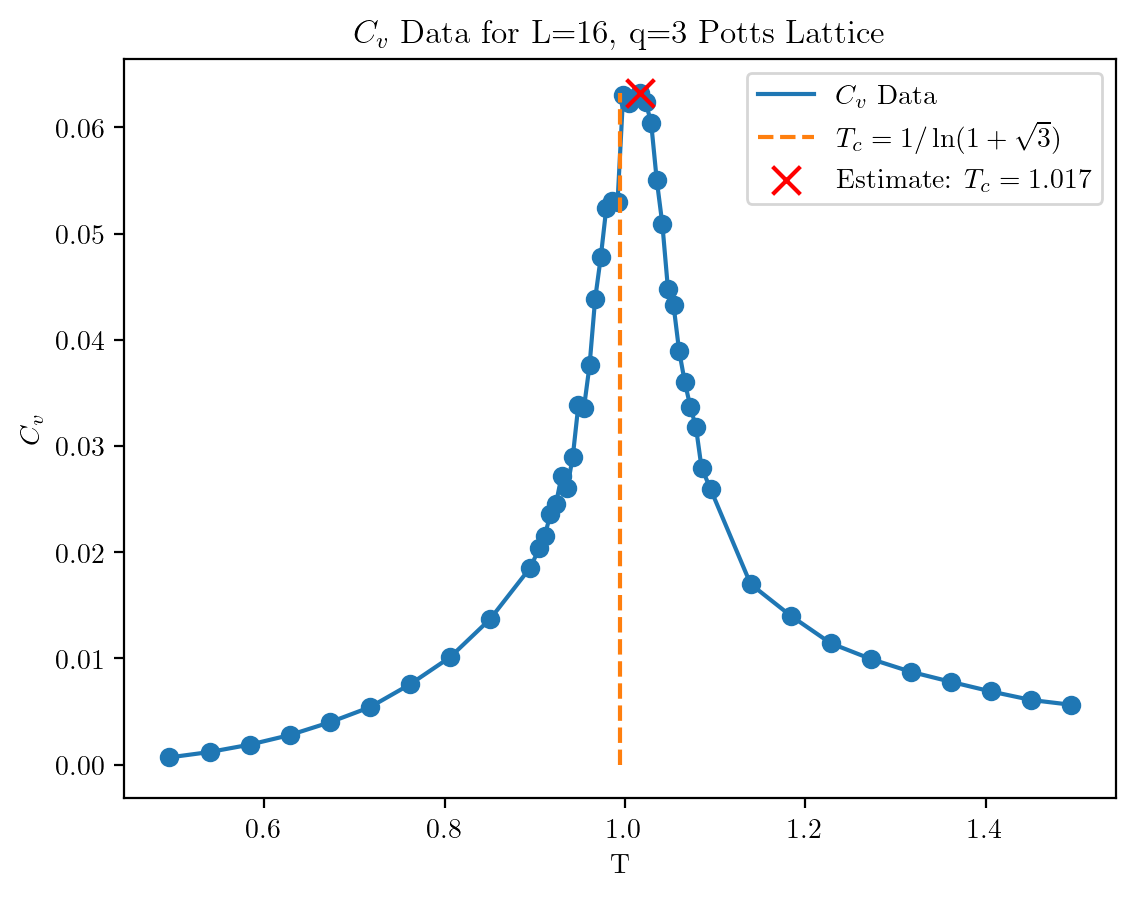

Estimate of Tc: 1.017
Error in estimate: 2.2%


In [268]:
plt.plot(temps, Cv16, label=r"$C_v$ Data")
plt.scatter(temps, Cv16)
plt.plot([Tc_act, Tc_act], [0, Cvmax], '--', label=r"$T_c = 1/\ln(1+\sqrt{3})$")
plt.scatter(Tc_est, Cvmax, marker='x', s=100, c='red', zorder=2.5, label=r'Estimate: $T_c={%.3f}$'%Tc_est)
plt.title(r'$C_v$ Data for L=16, q=3 Potts Lattice')
plt.ylabel(r'$C_v$')
plt.xlabel('T')
plt.legend()
plt.show()

print("Estimate of Tc: %.3f"%Tc_est)

print("Error in estimate: %.1f"%pdif + "%")

Surprisingly, we actually obtain a closer estimate of $T_c$ for the Potts model than for the 2D Ising model. This is most likely due to chance however, since any noise in the peak could artificially create a maximum, and if that happens close to $T_c$ then we would erroneously estimate a much lower percent difference. The most important thing is that we do in fact see a peak in the heat capacity in the vicinity of $T_c$.

### Part D: $\chi$ and Finite Scale Collapse

Once again, the procedure here is exactly the same as for the 2D Ising model, down to the definition of the susceptibility of the magnetization. 

In [269]:
chi12 = 12**2/temps*(L12M2-L12M**2)
chi16 = 16**2/temps*(L16M2-L16M**2)
chi20 = 20**2/temps*(L20M2-L20M**2)
chi24 = 24**2/temps*(L24M2-L24M**2)

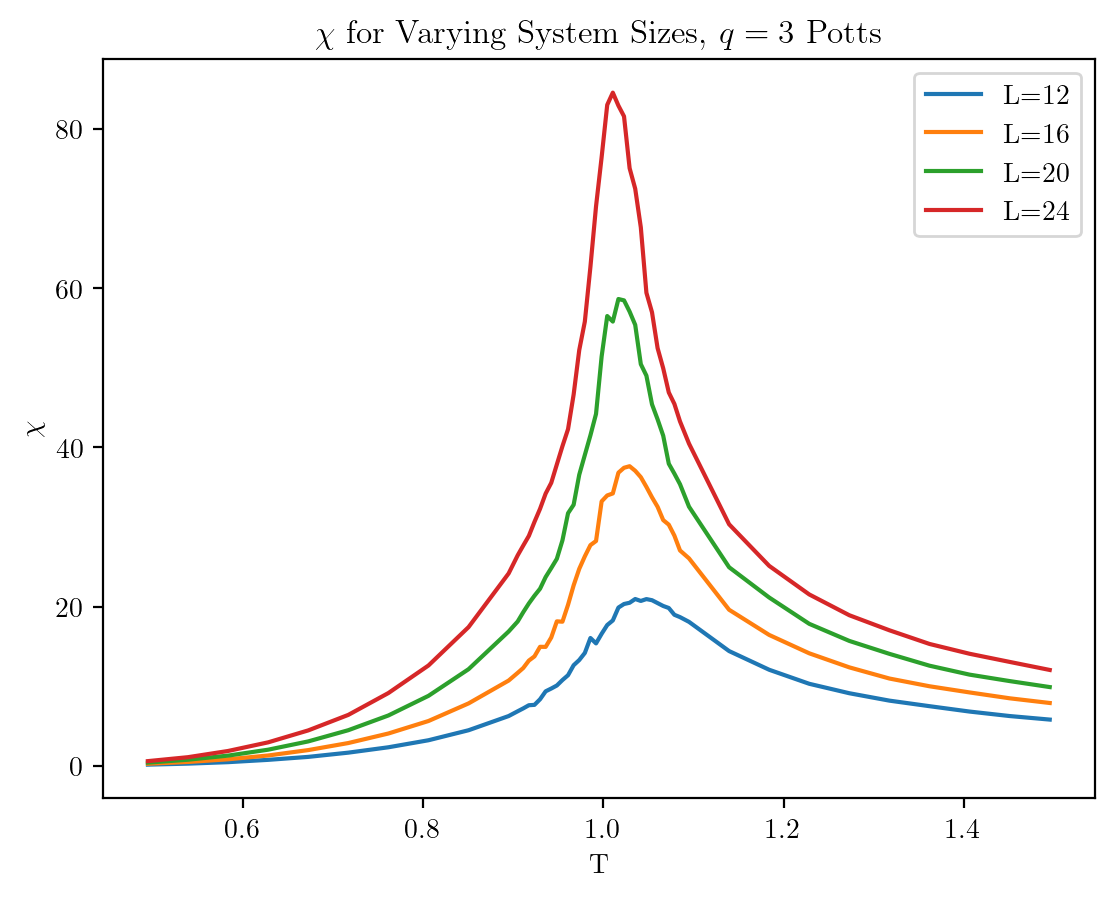

In [270]:
plt.plot(temps, chi12, label='L=12')
plt.plot(temps, chi16, label='L=16')
plt.plot(temps, chi20, label='L=20')
plt.plot(temps, chi24, label='L=24')
plt.title(r'$\chi$ for Varying System Sizes, $q=3$ Potts')
plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.legend()
plt.show()

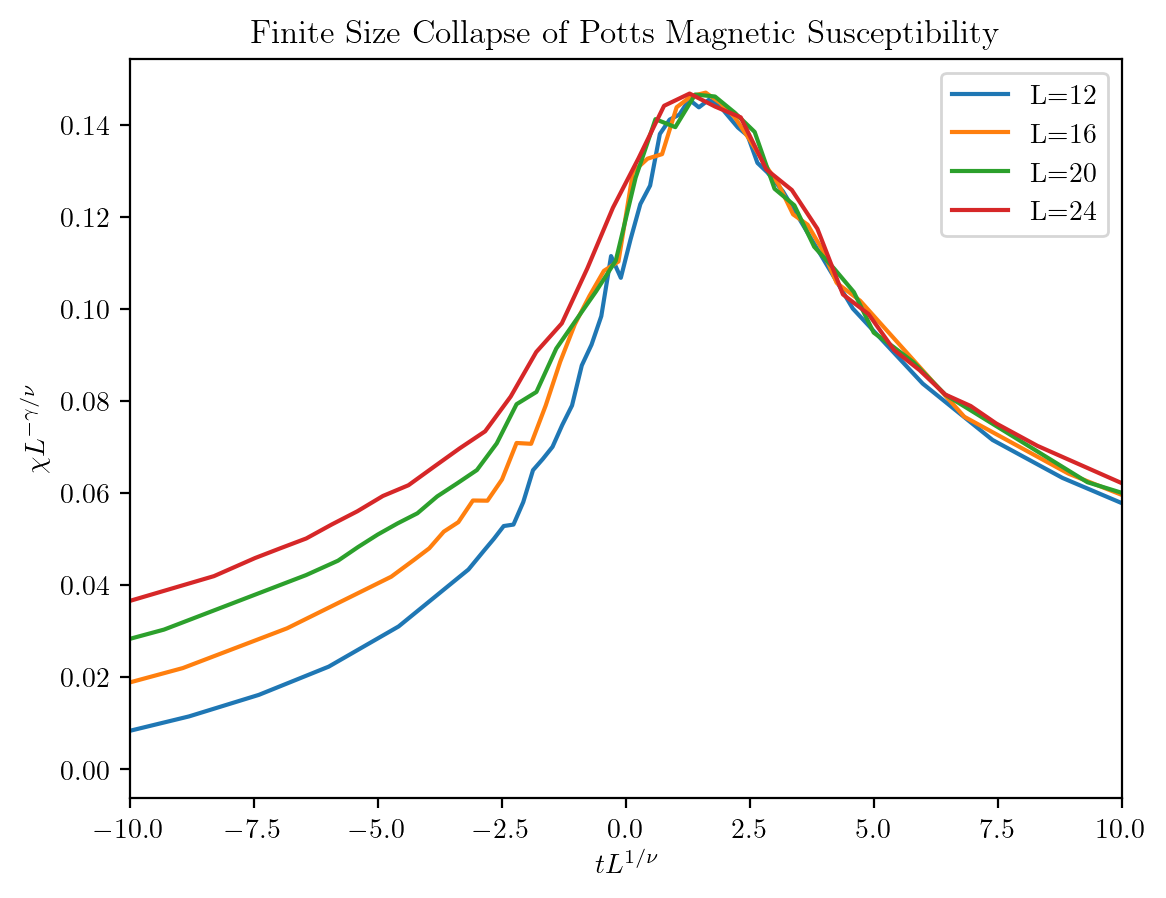

In [271]:
t = (temps-Tc_act)/Tc_act

gamma = 1.44
nu = 0.72

plt.plot(12**(1/nu)*t, 12**(-gamma/nu)*chi12, label='L=12')
plt.plot(16**(1/nu)*t, 16**(-gamma/nu)*chi16, label='L=16')
plt.plot(20**(1/nu)*t, 20**(-gamma/nu)*chi20, label='L=20')
plt.plot(24**(1/nu)*t, 24**(-gamma/nu)*chi24, label='L=24')
plt.title('Finite Size Collapse of Potts Magnetic Susceptibility')
plt.ylabel(r'$\chi L^{-\gamma/\nu}$')
plt.xlabel(r'$tL^{1/\nu}$')
plt.xlim(-10, 10)
plt.legend()
plt.show()

In [272]:
nu_diff = round(100*(5/6-nu)/(5/6), 3)
gam_diff = round(100*(13/9-gamma)/(13/9), 3)

print(f"Error in γ: {gam_diff}%\nError in ν: {nu_diff}%")

Error in γ: 0.308%
Error in ν: 13.6%


The critical exponents for the $q=3$ Potts model are $\nu=5/6$ and $\gamma=13/9$, and we obtained the best results using $\gamma = 1.44$ and $\nu = 0.72$. This is a very close agreement for $\gamma$ but a very large error in $\nu$. This is most likely a consequence of the number of MC steps we chose to use, or that we had to correct the magnetization data after the fact though this is less likely.

We can use the hyper-scaling relations to estimate $\alpha$ from this, which we can then compare to the results obtained from finite scale collapse of the heat capacity and the exact value of $\alpha$. Starting first with the hyper-scaling relation:

\begin{equation}
\tag{24}
\alpha = 2-d\nu
\end{equation}

This gives an exact value of $\alpha=1/3$, and an estimate from the collapse of $\chi$ of $\alpha=0.56$ which is much larger than it should be. We can perform a finite scaling collapse of the heat capacity to determine $\alpha$ instead, where we need to include a factor of $N$ since we are using the total energy per spin.

In [273]:
Cv12 = 12**2/temps**2 * (L12E2-L12E**2)
Cv16 = 16**2/temps**2 * (L16E2-L16E**2)
Cv20 = 20**2/temps**2 * (L20E2-L20E**2)
Cv24 = 24**2/temps**2 * (L24E2-L24E**2)

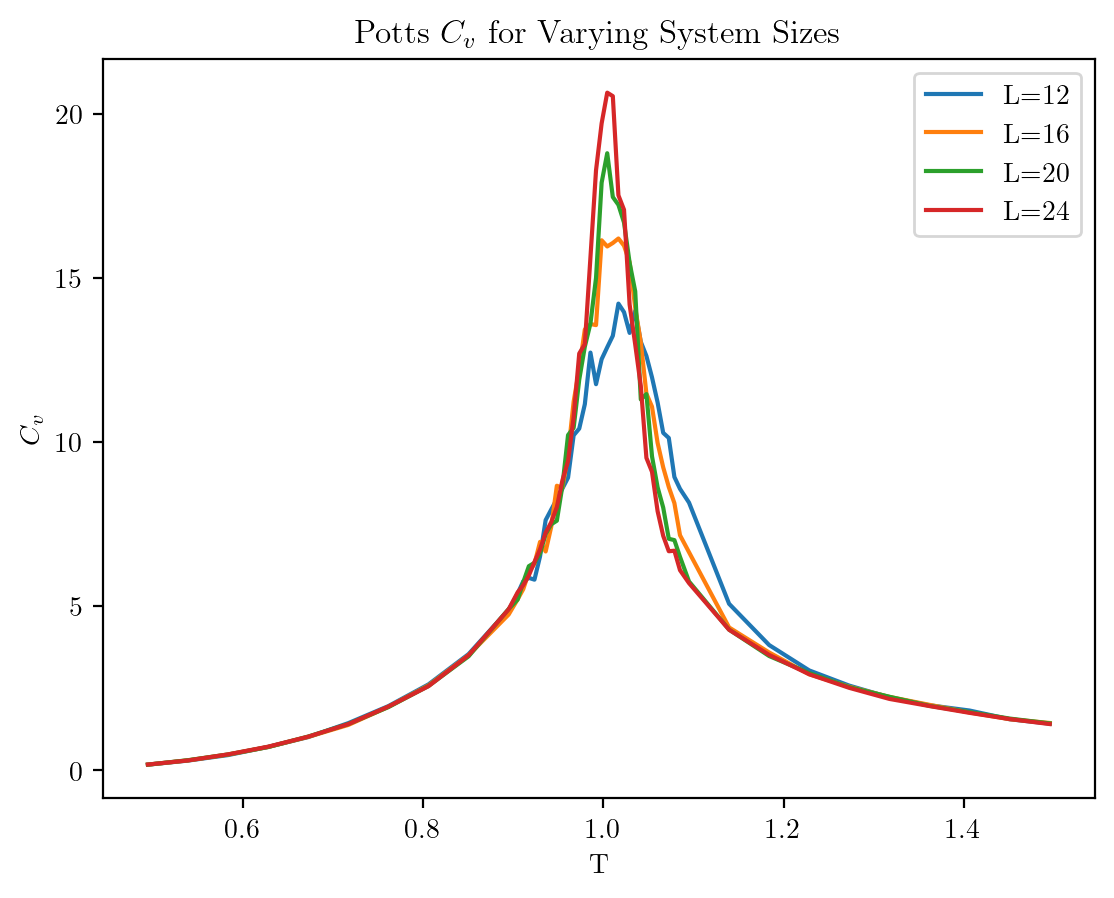

In [274]:
plt.plot(temps, Cv12, label='L=12')
plt.plot(temps, Cv16, label='L=16')
plt.plot(temps, Cv20, label='L=20')
plt.plot(temps, Cv24, label='L=24')
plt.title(r'Potts $C_v$ for Varying System Sizes')
plt.ylabel(r'$C_v$')
plt.xlabel('T')
plt.legend()
plt.show()

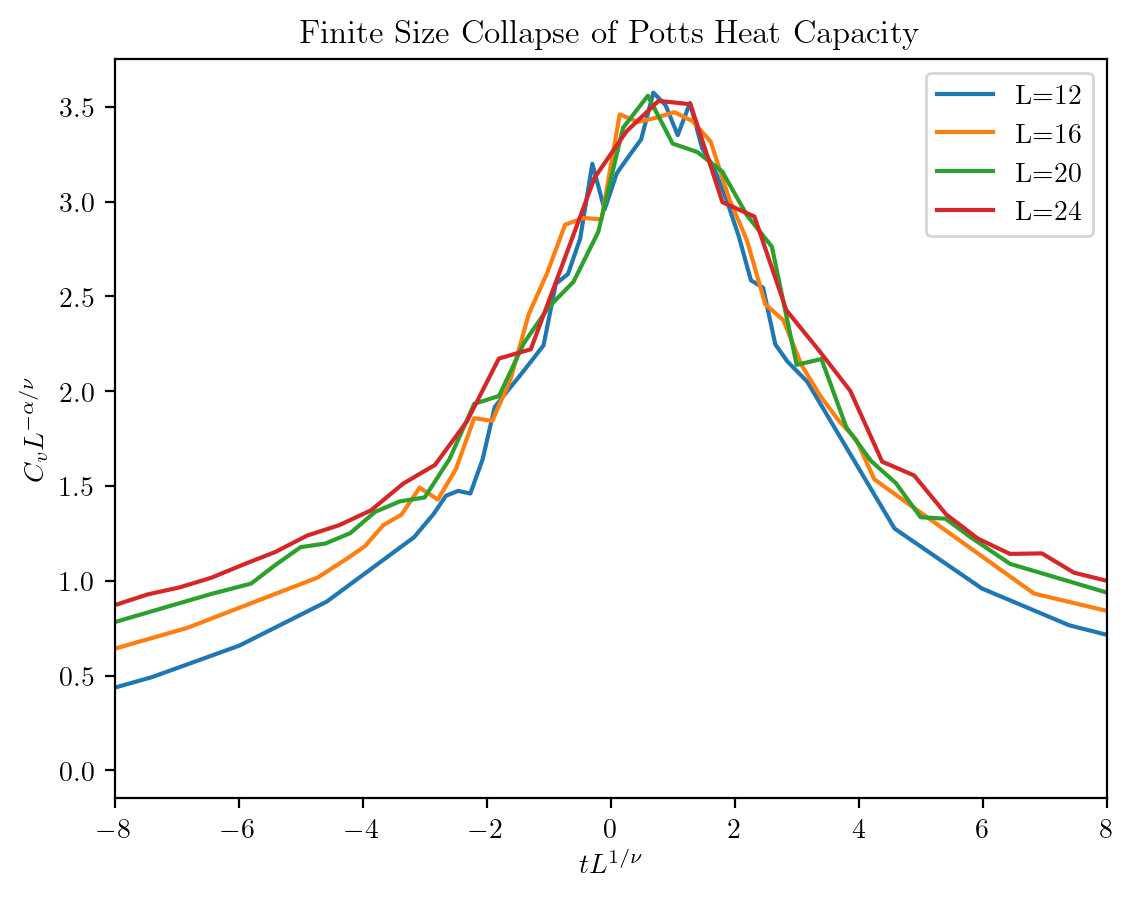

In [276]:
alpha = 0.4

plt.plot(12**(1/nu)*t, 12**(-alpha/nu)*Cv12, label='L=12')
plt.plot(16**(1/nu)*t, 16**(-alpha/nu)*Cv16, label='L=16')
plt.plot(20**(1/nu)*t, 20**(-alpha/nu)*Cv20, label='L=20')
plt.plot(24**(1/nu)*t, 24**(-alpha/nu)*Cv24, label='L=24')
plt.title('Finite Size Collapse of Potts Heat Capacity')
plt.ylabel(r'$C_v L^{-\alpha/\nu}$')
plt.xlabel(r'$tL^{1/\nu}$')
plt.xlim(-8,8)
plt.legend()
plt.show()

In [277]:
alp_diff = round(100*(alpha-1/3)/(1/3), 3)
print(f"Error in α: {alp_diff}%")

Error in α: 20.0%


Using this approach we obtain a value of $\alpha=0.4$, which while closer than the estimate from $\chi$ is still off by 20%, which strongly implies that this is a result of the number of MC steps and not the magnetization since this calculation relies only on the energy calculations. This is disappointing since we expected only a slight impact on the data from running for fewer MC steps, and is proof that $10^6$ is the lower bound for good results.

### Part E: First Order Transition for $q=10$ Potts Model

The characteristics of a first order transition are a jump discontinuity in the order parameter at the transition temperature, and a hysteresis across the transition temperature. To measure this, we take a randomized $L\times L$ lattice with $q=10$ and first cool through the transition to the ordered phase. After that, we then heat back through the transition into the disordered phase, with the goal of measuring a jump discontinuity and observing a hysteresis. This was done for system sizes of 12, 16, 20, and 24 and the magnetization was rescaled following the same procedure as in part c.

In [12]:
global potts_finite_scale10
def potts_finite_scale10(L):
    return(PottsSystem(1, L, 10).hysteresis())

Ls = [12, 16, 20, 24]
pool = mp.Pool(4) 
results = pool.map(potts_finite_scale10, Ls)
pool.close()

In [26]:
datafile = np.stack([results[i][j][k] for i in range(4) for j in range(len(results[0])) for k in range(len(results[0][0]))], axis=1)
datafile = pd.DataFrame(datafile)
datafile.to_csv('q10_potts data.csv', index=False, header=False)

In [278]:
data = np.loadtxt("q10_potts data.csv", delimiter=',')

L12EC = data[:,0]
L12E2C = data[:,1]
L12MC = data[:,2]
L12M2C = data[:,3]
L12EH = data[:,5]
L12E2H = data[:,6]
L12MH = data[:,7]
L12M2H = data[:,8]

L16EC = data[:,10]
L16E2C = data[:,11]
L16MC = data[:,12]
L16M2C = data[:,13]
L16EH = data[:,15]
L16E2H = data[:,16]
L16MH = data[:,17]
L16M2H = data[:,18]

L20EC = data[:,20]
L20E2C = data[:,21]
L20MC = data[:,22]
L20M2C = data[:,23]
L20EH = data[:,25]
L20E2H = data[:,26]
L20MH = data[:,27]
L20M2H = data[:,28]

L24EC = data[:,30]
L24E2C = data[:,31]
L24MC = data[:,32]
L24M2C = data[:,33]
L24EH = data[:,35]
L24E2H = data[:,36]
L24MH = data[:,37]
L24M2H = data[:,38]

tempsC = data[:,4]
tempsH = data[:,9]

In [279]:
L12MC = (L12MC-(1/10))/(1-(1/10))
L16MC = (L16MC-(1/10))/(1-(1/10))
L20MC = (L20MC-(1/10))/(1-(1/10))
L24MC = (L24MC-(1/10))/(1-(1/10))
L12MH = (L12MH-(1/10))/(1-(1/10))
L16MH = (L16MH-(1/10))/(1-(1/10))
L20MH = (L20MH-(1/10))/(1-(1/10))
L24MH = (L24MH-(1/10))/(1-(1/10))

L12M2C = (L12M2C-(1/100))/(1-(1/100))
L16M2C = (L16M2C-(1/100))/(1-(1/100))
L20M2C = (L20M2C-(1/100))/(1-(1/100))
L24M2C = (L24M2C-(1/100))/(1-(1/100))
L12M2H = (L12M2H-(1/100))/(1-(1/100))
L16M2H = (L16M2H-(1/100))/(1-(1/100))
L20M2H = (L20M2H-(1/100))/(1-(1/100))
L24M2H = (L24M2H-(1/100))/(1-(1/100))

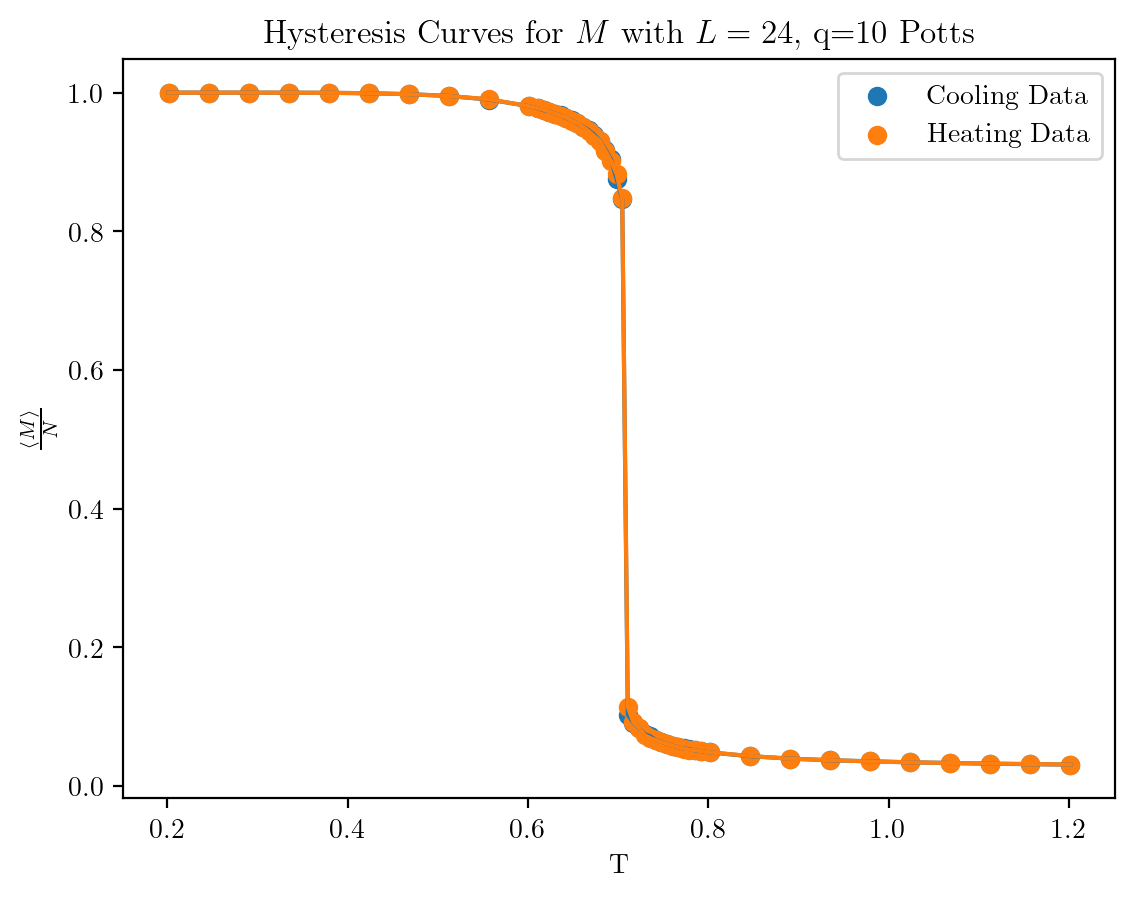

In [280]:
plt.plot(tempsC, L24MC)
plt.scatter(tempsC, L24MC, label='Cooling Data')
plt.plot(tempsH, L24MH)
plt.scatter(tempsH, L24MH, label='Heating Data')
plt.title(r"Hysteresis Curves for $M$ with $L=24$, q=10 Potts")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle M \rangle}{N}$")
plt.legend()
plt.show()

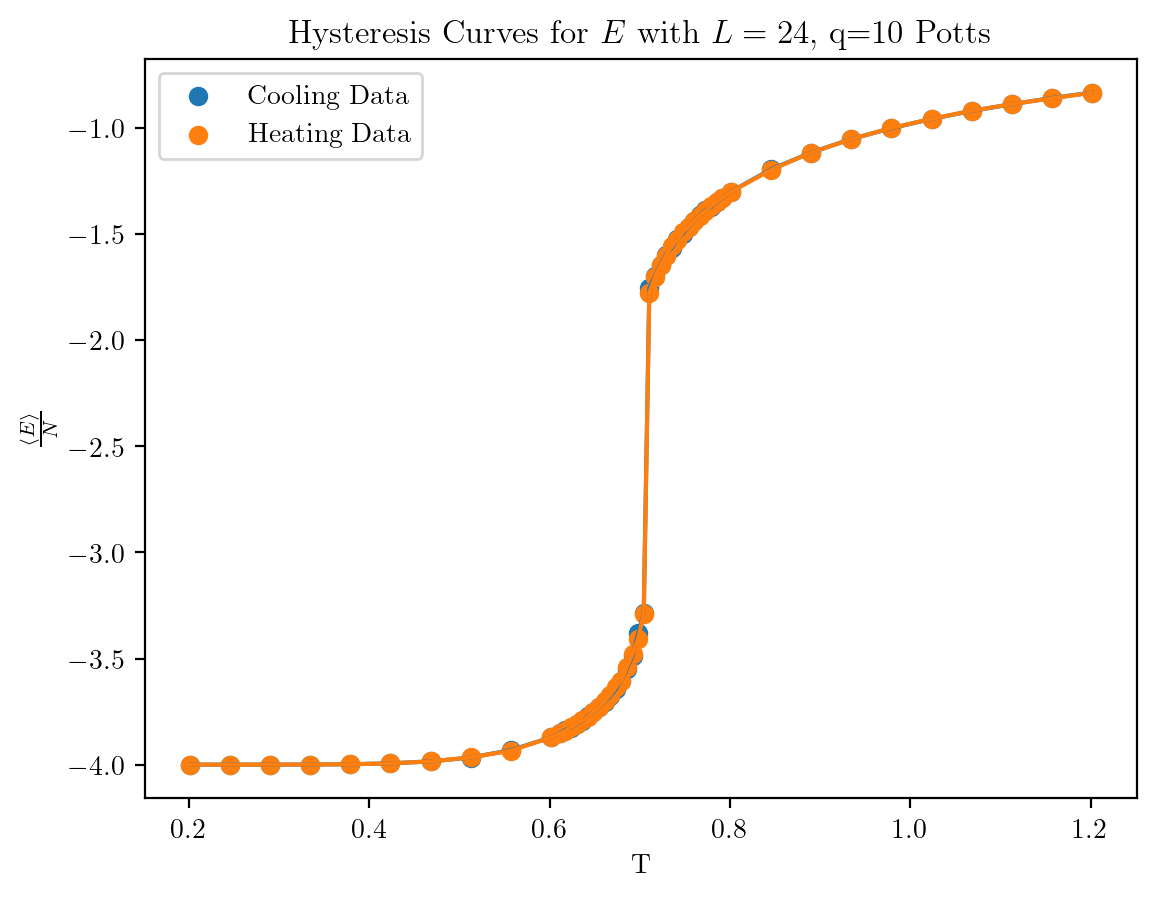

In [281]:
plt.plot(tempsC, L24EC)
plt.scatter(tempsC, L24EC, label='Cooling Data')
plt.plot(tempsH, L24EH)
plt.scatter(tempsH, L24EH, label='Heating Data')
plt.title(r"Hysteresis Curves for $E$ with $L=24$, q=10 Potts")
plt.xlabel("T")
plt.ylabel(r"$\frac{\langle E \rangle}{N}$")
plt.legend()
plt.show()

In [282]:
max_loc = np.where(np.gradient(L24MC) == max(np.gradient(L24MC)))

Tc_est = round(float(tempsC[max_loc]), 3)
Tc_act = round(1/np.log(1+np.sqrt(10)), 3)
pdiff = round(100*abs(Tc_act-Tc_est)/Tc_act, 3)

print(f"Estimate of Tc: {Tc_est}\nActual Tc: {Tc_act}\nError in Tc: {pdiff}%")

Estimate of Tc: 0.704
Actual Tc: 0.701
Error in Tc: 0.428%


Sadly we do not observe a hysteresis while cooling and heating across thr transition. Velytsky $^[4]$ et al. observe hysteresis curves for this system, however they use a lattice size of $L=80$, which would take far too long to compute for this project. So it is either that our systems are too small, even at $L=24$, or we are once again limited by using $10^5$ MC steps. 

What we do have however is strong evidence of a jump discontinuity at a temperature of $T=0.704$, which differs from the actual critical temperature by just 0.4%. 

So while we were unable to observe a hysteresis, we were still able to verify the first order phase transition nature of the $q=10$ Potts model, and successfully identify the critical transition temperature. For even further evidence of a first order transition we can examine the scaling of the susceptibility and heat capacity curves.

### Part F: Finite Size Scaling of First Order Transitions

The peaks in the heat capacity and susceptibility data scale as $L^d$, and Landau and Binder have a good argument for why this is the case $^{[1]}$. For a first order transition, specifically for the magnetization, there are two values of the magnetization that the system may spontaneously take. They represent this as two gaussians centred on the values $\pm M_{sp}$. The probability distribution for magnetization $m$ with external field $h$ is:

\begin{equation}
\tag{25}
P_L(m) = A\left(\text{e}^{-((m-M_L)^2-2\chi h)L^d/2T\chi(L)} + \text{e}^{-((m+M_L)^2-2\chi h)L^d/2T\chi(L)} \right)
\end{equation}

Using this probability definition it is possible to determine the expectation values of $m$:

\begin{equation}
\tag{26}
\langle m \rangle \approx \chi h + M_{sp}\tanh\left(\frac{hM_{sp}L^d}{T}\right)
\end{equation}

From which they obtain a susceptibility of:

\begin{equation}
\tag{27}
\chi_L = \chi +\frac{M^2_{sp}L^d}{T\cosh^2\left(\frac{hM_{sp}L^d}{T}\right)}
\end{equation}

From which we find that for the susceptibility, the peak now scales as $L^d$ and no longer depends on the critical exponents. 

We should note that this is only for the Ising model, where the first order phase transition is magnetic field driven. In the Potts model for $q>4$, the first order transition is driven by temperature and so a different probability distribution needs to be defined in terms of the energy per lattice site. Following the same procedure as above, it is possible to show that the peak of the specific heat is given by:

\begin{equation}
\tag{28}
C_L|_{max} \approx \frac{C_{+} + C_{-}}{2} + \frac{(E_{+} + E_{-})^2L^d}{4T^2}
\end{equation}

Which we once again see scales as $L^d$. First we present our unscaled heat capacity and susceptibility data:

In [292]:
Cv12 = 1/tempsC**2 * (L12E2C-L12EC**2)
Cv16 = 1/tempsC**2 * (L16E2C-L16EC**2)
Cv20 = 1/tempsC**2 * (L20E2C-L20EC**2)
Cv24 = 1/tempsC**2 * (L24E2C-L24EC**2)

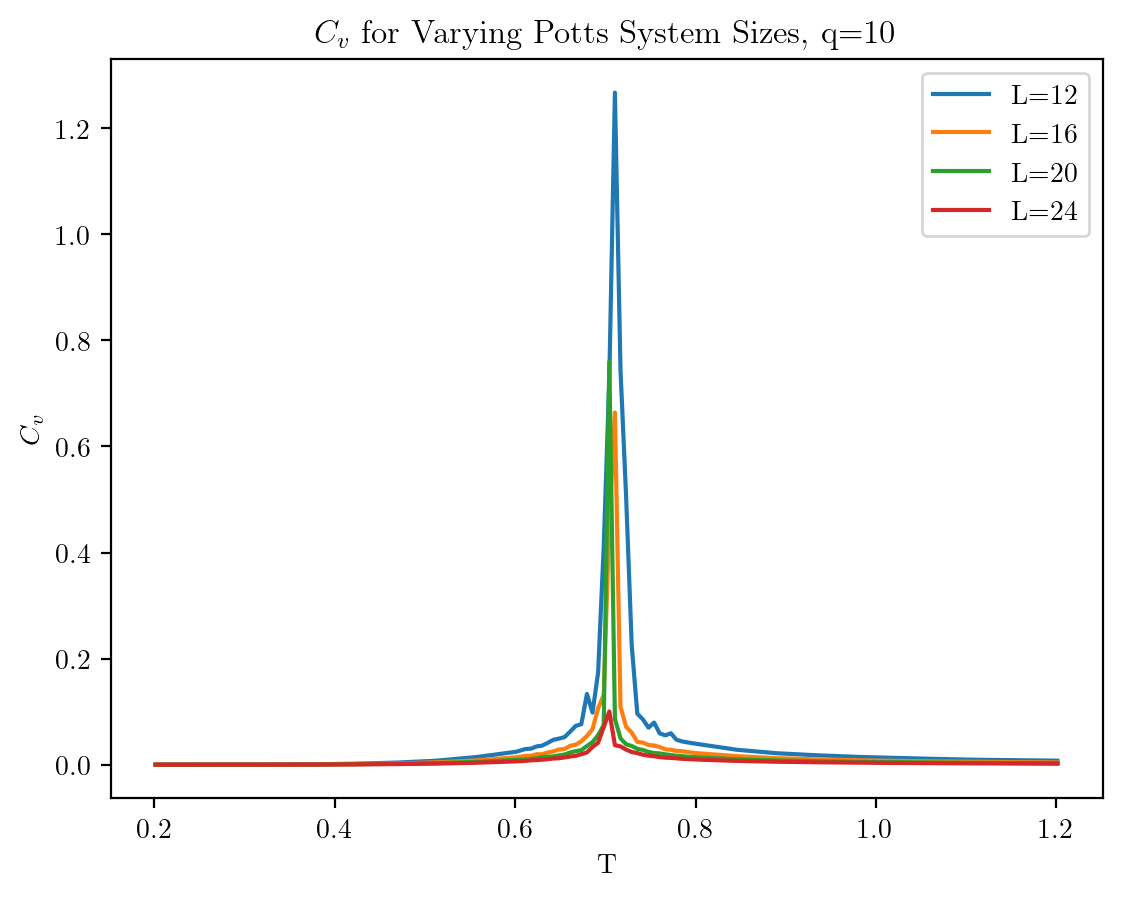

In [293]:
plt.plot(tempsC, Cv12, label='L=12')
plt.plot(tempsC, Cv16, label='L=16')
plt.plot(tempsC, Cv20, label='L=20')
plt.plot(tempsC, Cv24, label='L=24')
plt.title(r'$C_v$ for Varying Potts System Sizes, q=10')
plt.ylabel(r'$C_v$')
plt.xlabel('T')
plt.legend()
plt.show()

In [288]:
chi12 = 12**2/tempsC*(L12M2C-L12MC**2)
chi16 = 16**2/tempsC*(L16M2C-L16MC**2)
chi20 = 20**2/tempsC*(L20M2C-L20MC**2)
chi24 = 24**2/tempsC*(L24M2C-L24MC**2)

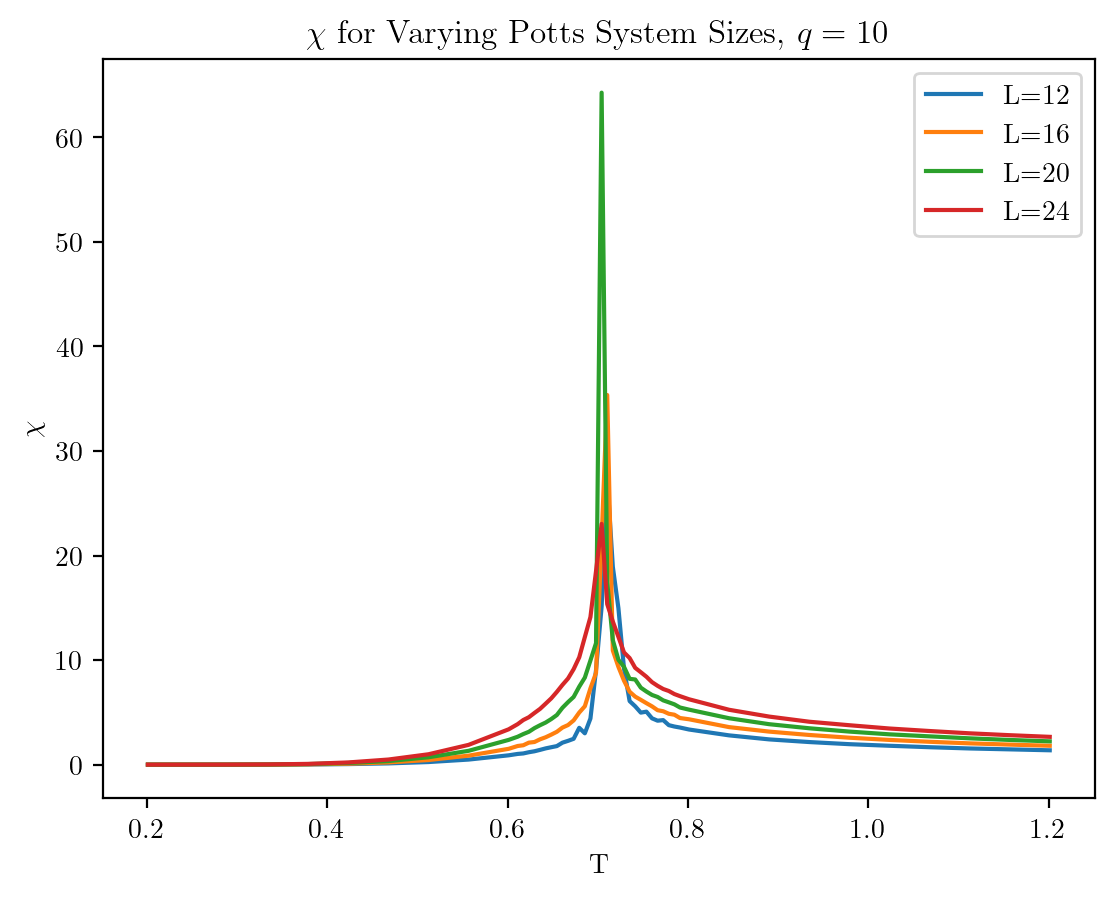

In [294]:
plt.plot(tempsC, chi12, label='L=12')
plt.plot(tempsC, chi16, label='L=16')
plt.plot(tempsC, chi20, label='L=20')
plt.plot(tempsC, chi24, label='L=24')
plt.title(r'$\chi$ for Varying Potts System Sizes, $q=10$')
plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.legend()
plt.show()

From these plots we see a strong divergence around the critical temperature, though it doesn't look like the peak position is actually changing. If we apply the appropriate scaling to the data we obtain:

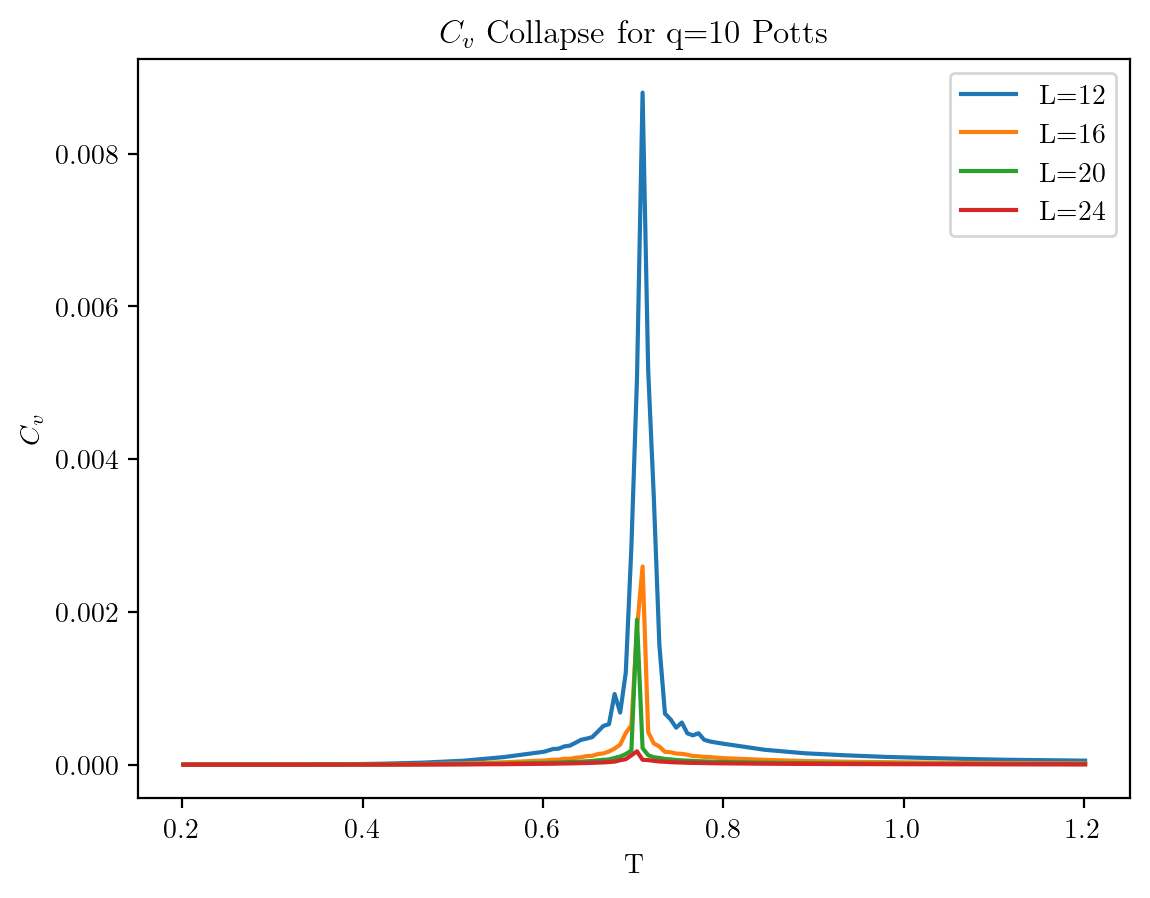

In [295]:
plt.plot(tempsC, (1/12**2)*Cv12, label='L=12')
plt.plot(tempsC, (1/16**2)*Cv16, label='L=16')
plt.plot(tempsC, (1/20**2)*Cv20, label='L=20')
plt.plot(tempsC, (1/24**2)*Cv24, label='L=24')
plt.title(r'$C_v$ Collapse for q=10 Potts')
plt.ylabel(r'$C_v$')
plt.xlabel('T')
plt.legend()
plt.show()

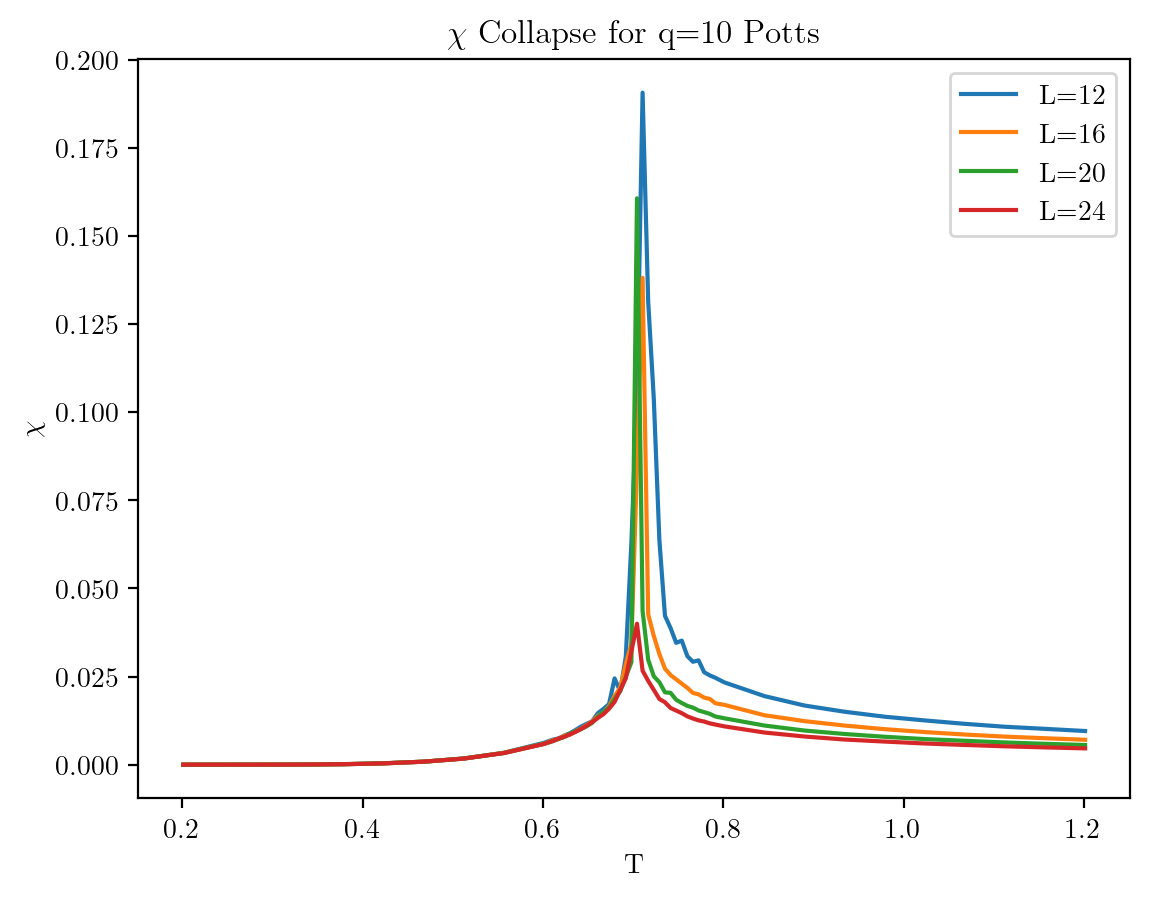

In [296]:
plt.plot(tempsC, (1/12**2)*chi12, label='L=12')
plt.plot(tempsC, (1/16**2)*chi16, label='L=16')
plt.plot(tempsC, (1/20**2)*chi20, label='L=20')
plt.plot(tempsC, (1/24**2)*chi24, label='L=24')
plt.title(r'$\chi$ Collapse for q=10 Potts')
plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.legend()
plt.show()

From this we find that while the scaling does have the effect of bringing the peaks closer together, there is always one peak which is either far too small or far too large. This could be due to the data density, since it is the same for each system size. If the relative speed of the transition compared to the temperature resolution is large, then we will do a poorer job of capturing the divergence of $C_v$ and $\chi$ for that system. If that speed is then a property of system size, which seems to be the case here, then this is a systematic error that could be remedied by increasing the data resolution to better capture the transition of the smaller systems.

### Conclusions

We were very successfully able to model the $q=3$ Potts model using an adapted version of the code for the 2D Ising model. We defined an order parameter which captured the phase transition, but was unphysical in its original form. By applying a rescaling, we were able to align our order parameter for the 2D Potts model with the one which is most commonly cited in literature. 

From this order parameter we were able to plot the susceptibility and perform a collapse of the data to extract $\gamma$ and $\nu$, to 0.3% and 13% respectively. The biggest source of error here was likely the noise introduced by using one tenth of the number of MC steps compared to the Ising model simulations in order to save on computation time. These values of $\gamma$ and $\nu$ were used to make an estimate of $\alpha$ with the hyper-scaling relations that differed greatly from the theoretical value, likely a result of compounding the errors in the data. 

Examining the collapse of the heat capacity data gave a much better result than the hyper-scaling estimate, but even this differed from the theoretical value by 20%. We have managed to prove that this code can successfully simulate the 2D Potts model, but to improve these results the first step would be to collect the data again using at least $10^6$ MC steps, which should reduce the error significantly. 

This issue also affects the data for the $q=10$ system, which we were unable to see a hysteresis in neither the energy data nor the magnetization data. We did see a jump discontinuity in both of these plots however, which is clear evidence of a first order phase transition. The location of this jump was used to determine the transition temperature, which we found to 0.4% error, much better than the 2% error in the $T_c$ estimation for the $q=3$ model, done through the peak of the heat capacity. 

An attempted finite size collapse of the heat capacity and susceptibility yielded poor results, which can most likely be attributed to capturing differing portions of the transition for each system size, and could be remedied by increasing the data resolution near the transition. 

Ultimately, with more computation time dedicated, this code could produce highly accurate results from simulating the $q$-state Potts model.

### Bibliography

1. Landau, David, and Kurt Binder. A guide to Monte Carlo simulations in statistical physics. Cambridge university press, 2021.
2. Wikipedia contributors. (2022, July 23). Universality class. In Wikipedia, The Free Encyclopedia. Retrieved 20:11, April 21, 2023, from https://en.wikipedia.org/w/index.php?title=Universality_class&oldid=1099950998
3. Attila Boer, Monte Carlo simulation of the two-dimensional Potts model using nonextensive statistics Physica A: Statistical Mechanics and its Applications, Volume 390, Issues 23–24, 2011, Pages 4203-4209, ISSN 0378-4371, https://doi.org/10.1016/j.physa.2011.07.027
4. Alexander Velytsky, Bernd A. Berg, Urs M. Heller, Dynamics of the 2d Potts model phase transition, Nuclear Physics B - Proceedings Supplements, Volume 119, 2003, Pages 861-863, ISSN 0920-5632, https://doi.org/10.1016/S0920-5632(03)01703-1